## Wstępna Analiza Danych - MOW 2
### 2016 UK Road Safety: Traffic Accidents and Vehicles

Anastazja Kandratsiuk, Bartosz Bojarski

Opis zbioru:
Zbiór danych zawiera informacje o wszystkich wypadkach drogowych w Wielkiej Brytani z roku 2016. Dane zostały przygotowane przez Departament Transportu Wielkiej Brytanii i przez inicjatywę Open Gov. Oryginalne dane są podzielone na cztery pliki, które opisują parametry dotyczące ofiar, pojazdów, czy okoliczności wypadków. Zostały one połączone w dwa zbiory danych, jeden opisujący geolokację wypadków, a drugi zawierający wszystkie pozostałe informacje.  
Część kolumn jest przygotowana w formie kodów, które wymagają przetłumaczenia na zrozumiałe wartości. Będzie to robione przy pomocy słowników, które zostały dostarczone wraz z danymi, a sama translacja będzie wykonywana w trakcie analizy danych.



Import bibliotek

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

from shapely.geometry import Point


Wczytanie danych

In [77]:
Casualties = pd.read_csv('dane/Cas.csv')
MakeModel = pd.read_csv('dane/MakeModel2016.csv')
Accidents = pd.read_csv('dane/dftRoadSafety_Accidents_2016.csv', low_memory=False)
Vehicles = pd.read_csv('dane/Veh.csv')

Rozbicie danych na dane geograficzne i pozostałe

In [78]:
Comp_data = pd.merge(Accidents, Casualties, on='Accident_Index')
Comp_data = pd.merge(Comp_data, Vehicles, on='Accident_Index')
Comp_data = pd.merge(Comp_data, MakeModel, on='Accident_Index')

Geo_data = pd.DataFrame(Comp_data, columns=['Accident_Index', 'Location_Easting_OSGR', 'Location_Northing_OSGR', 'Longitude', 'Latitude'])
Data_no_geo = Comp_data.drop(['Location_Easting_OSGR', 'Location_Northing_OSGR', 'Longitude', 'Latitude'], axis=1)

### Prezentacja podstawowych danych zbioru danych

Zbiór danych posiada 92 kolumny i 804853 wiersze. Kluczem głównym dla zbioru danych jest kolumna 'Accident_Index'. 
Kolejne cztery kolumny zawierają informacje o geolokalizacji wypadków. Pozostałe kolumny zawierają informacje o wypadkach, ofiarach, pojazdach, czy okolicznościach wypadków.

In [79]:
Comp_data.head()

,Accident_Index,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,...,Journey_Purpose_of_Driver_y,Sex_of_Driver_y,Age_Band_of_Driver_y,Engine_Capacity_(CC)_y,Propulsion_Code_y,Age_of_Vehicle_y,Driver_IMD_Decile_y,Driver_Home_Area_Type_y,make,model
0,2016010000005,519310.0,188730.0,-0.279323,51.584754,1,3,2,1,01/11/2016,...,1,1,8,-1,-1,-1,3,1,NaN,NaN
1,2016010000005,519310.0,188730.0,-0.279323,51.584754,1,3,2,1,01/11/2016,...,6,1,5,124,1,4,4,1,YAMAHA,HW 125 XENTER
2,2016010000005,519310.0,188730.0,-0.279323,51.584754,1,3,2,1,01/11/2016,...,1,1,8,-1,-1,-1,3,1,NaN,NaN
3,2016010000005,519310.0,188730.0,-0.279323,51.584754,1,3,2,1,01/11/2016,...,6,1,5,124,1,4,4,1,YAMAHA,HW 125 XENTER
4,2016010000006,551920.0,174560.0,0.184928,51.449595,1,3,1,1,01/11/2016,...,6,2,7,1461,2,1,10,1,MERCEDES,A180 BLUEEFFICIENCY SPORT CDI


In [80]:
Data_no_geo.describe()

,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Day_of_Week,Local_Authority_(District),1st_Road_Class,1st_Road_Number,Road_Type,Speed_limit,...,1st_Point_of_Impact_y,Was_Vehicle_Left_Hand_Drive,Journey_Purpose_of_Driver_y,Sex_of_Driver_y,Age_Band_of_Driver_y,Engine_Capacity_(CC)_y,Propulsion_Code_y,Age_of_Vehicle_y,Driver_IMD_Decile_y,Driver_Home_Area_Type_y
count,804853.000000,804853.000000,804853.000000,804853.000000,804853.000000,804853.000000,804853.000000,804853.000000,804853.000000,804679.000000,...,804853.000000,804853.000000,804853.000000,804853.000000,804853.000000,804853.000000,804853.000000,804853.000000,804853.000000,804853.000000
mean,30.762009,2.801886,2.722990,2.197789,4.102374,354.275910,3.825053,881.748876,5.028114,41.791845,...,1.745326,0.999745,4.751142,1.417705,6.122138,1537.945788,1.051839,5.871495,3.698314,0.932550
std,24.362049,0.445092,1.434966,2.020741,1.933958,249.474336,1.502124,1710.898103,1.663407,15.799111,...,1.095624,0.129218,1.978891,0.611939,2.903485,1625.727781,1.290594,5.855146,3.665153,1.086339
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,-1.000000,20.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,10.000000,3.000000,2.000000,1.000000,2.000000,139.000000,3.000000,0.000000,3.000000,30.000000,...,1.000000,1.000000,3.000000,1.000000,5.000000,998.000000,1.000000,1.000000,-1.000000,1.000000
50%,32.000000,3.000000,2.000000,2.000000,4.000000,346.000000,3.000000,62.000000,6.000000,30.000000,...,1.000000,1.000000,6.000000,1.000000,7.000000,1498.000000,1.000000,5.000000,4.000000,1.000000
75%,46.000000,3.000000,3.000000,3.000000,6.000000,530.000000,6.000000,614.000000,6.000000,60.000000,...,2.000000,1.000000,6.000000,2.000000,8.000000,1968.000000,2.000000,10.000000,7.000000,1.000000
max,98.000000,3.000000,16.000000,58.000000,7.000000,941.000000,6.000000,9918.000000,9.000000,70.000000,...,4.000000,2.000000,6.000000,3.000000,11.000000,91000.000000,12.000000,75.000000,10.000000,3.000000


### Sprawdzenie brakujących danych

W zbiorze danych znajdują się brakujące dane w niektórych kolumnach. By spełnić wymagania projektu, będziemy dodawać brakujące dane w kolumnach, które będą analizowane, by osiągnąć poziom około 10% brakujących danych. W chwili obecnej najwięcej brakujących danych mamy w przypadku informacji o modelu auta (około 15% brakujących danych), a następnie informacje o jednostce geograficznej w której doszło do wypadku (około 5% brakujących danych). Jednak ta metoda sprawdzania wartości brakujących jest niewystarczająca, ponieważ w zakodowanych kolumnach wartość -1 oznacza brakujące dane.

In [81]:
miss_data = Comp_data.isnull().sum()
miss_data = miss_data[miss_data >= 1]
print("Missing data that > 0:")
print(miss_data)

Missing data that > 0:
Location_Easting_OSGR            50
Location_Northing_OSGR           50
Longitude                        50
Latitude                         50
Time                             19
Speed_limit                     174
LSOA_of_Accident_Location     44515
make                         120749
model                        120749
dtype: int64


Przykładowa analiza dla prędkości limitów

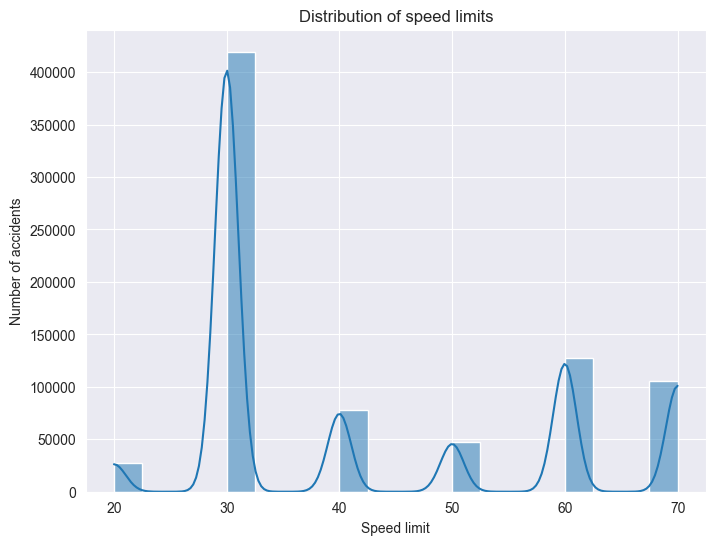

In [82]:
# Histogram prędkości limitów
plt.figure(figsize=(8, 6))
sns.histplot(Comp_data['Speed_limit'], bins=20, kde=True)
plt.title('Distribution of speed limits')
plt.xlabel('Speed limit')
plt.ylabel('Number of accidents')
plt.show()

Dodanie wykresu histogramu i pudełkowego dla prędkości limitów umożliwia nam lepsze zrozumienie rozkładu prędkości w danych dotyczących wypadków drogowych. Histogram prezentuje nam dystrybucję prędkości limitów na drogach, co pozwala zobaczyć, w jakich przedziałach prędkości występuje najwięcej wypadków (z wykresu wyżej widać że jest to 30 mil na godzinę).  Z kolei wykres pudełkowy pozwala nam zidentyfikować wartości odstające oraz zakres prędkości, w którym znajduje się większość obserwacji. 

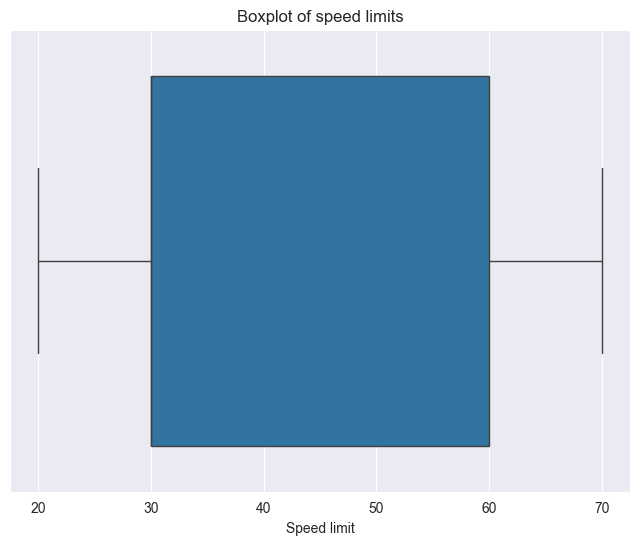

Descriptive statistics for speed limits:
count    804679.000000
mean         41.791845
std          15.799111
min          20.000000
25%          30.000000
50%          30.000000
75%          60.000000
max          70.000000
Name: Speed_limit, dtype: float64


In [83]:
# Wykres pudełkowy prędkości limitów
plt.figure(figsize=(8, 6))
sns.boxplot(x=Comp_data['Speed_limit'])
plt.title('Boxplot of speed limits')
plt.xlabel('Speed limit')
plt.show()

# Statystyki opisowe prędkości limitów
print("Descriptive statistics for speed limits:")
print(Comp_data['Speed_limit'].describe())

Na podstawie danych dotyczących prędkości limitów można wywnioskować:
1. Średnia prędkość limitu wynosi około 41.79 mil na godzinę.
2. Odchylenie standardowe wynoszące około 15.80 sugeruje, że rozrzut prędkości limitów między wypadkami był stosunkowo niewielki w porównaniu do średniej wartości.
3. Wartości kwartyla 25% i 50% są identyczne i wynoszą 30 mil na godzinę, co oznacza, że większość wypadków miała miejsce na obszarach o niższej prędkości limitu.
4. Wartość maksymalna prędkości limitu wynosi 70 mil na godzinę. Występowanie przypadków wypadków na obszarach o wyższych prędkościach limitów może wskazywać na potencjalnie większe ryzyko dla bezpieczeństwa drogowego.

Analiza prędkości limitów według marki auta

In [84]:
missing_data_make = Comp_data.groupby('make')['Speed_limit'].apply(lambda x: x.isnull().sum())
missing_data_make = missing_data_make[missing_data_make != 0]
print(missing_data_make)

make
AUDI          14
BMW            7
CITROEN        9
FORD          22
IVECO          2
KIA            2
MAZDA          2
MERCEDES       6
MINI           2
MITSUBISHI     2
NISSAN         4
PEUGEOT        6
RENAULT        4
SUZUKI         2
TOYOTA         1
VAUXHALL      17
VOLKSWAGEN    13
Name: Speed_limit, dtype: int64


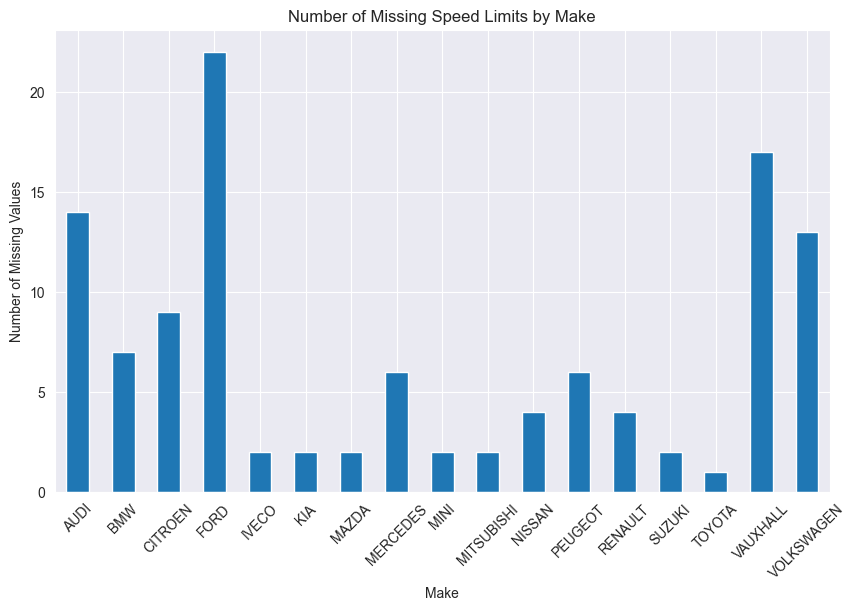

In [85]:
plt.figure(figsize=(10, 6))
missing_data_make.plot(kind='bar')
plt.title('Number of Missing Speed Limits by Make')
plt.xlabel('Make')
plt.ylabel('Number of Missing Values')
plt.xticks(rotation=45)
plt.show()

Analiza danych brakujących dotyczących prędkości pojazdów dla różnych marek samochodów pokazuje, że marka FORD, VAUXHALL, AUDI oraz Volkswagen są szczególnie narażone na braki danych. To może sugerować, że dla tych konkretnych marek istnieje większe ryzyko braku rejestracji prędkości pojazdów w przypadku wypadków drogowych. 


### Histogramy

Poniżej zaprezentowane są histogramy dla wybranych kolumn. Zaprezentowanie wszystkich histogramów w ramach jednego polecenia uniemożliwia wygodne odczytanie wartości z histogramów. Część z kolumn jest też zakodowana, więc nie ma sensu prezentować ich histogramów.

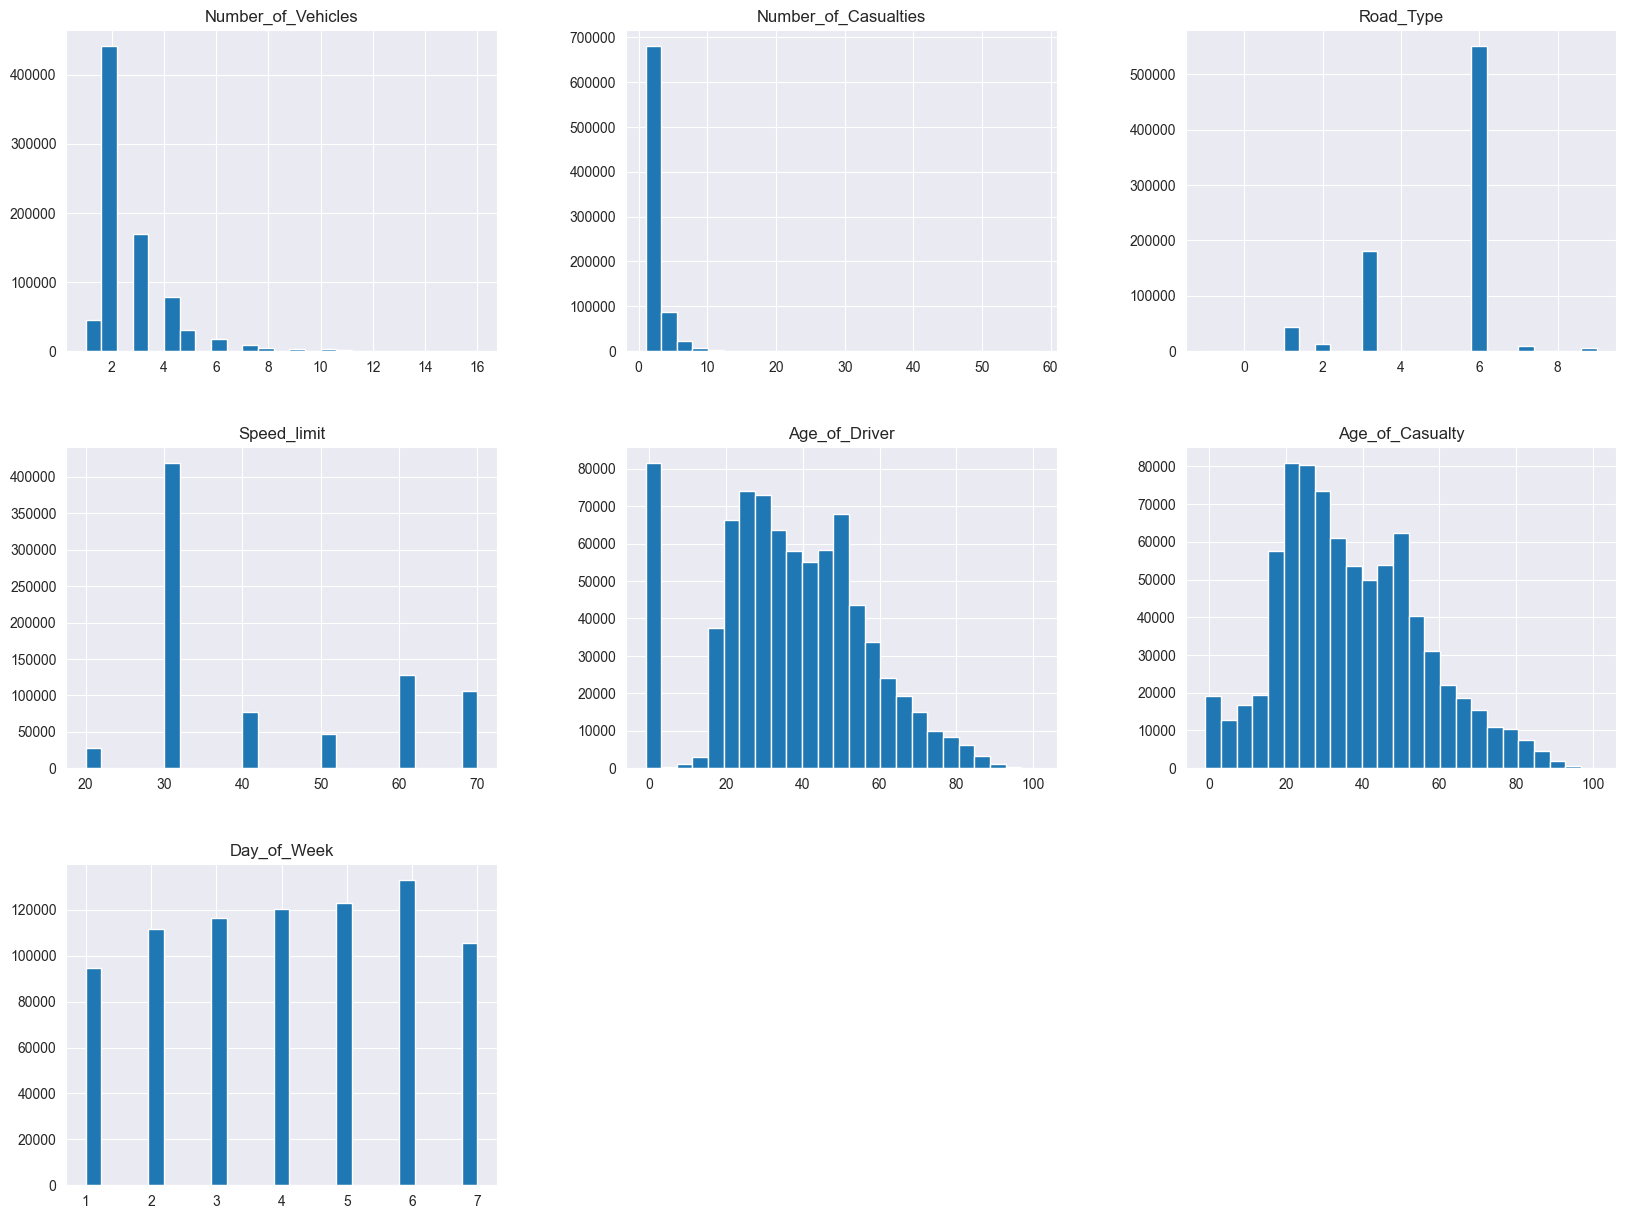

In [86]:
hist_subset = pd.DataFrame(Data_no_geo, columns=['Number_of_Vehicles', 'Number_of_Casualties', 'Road_Type', 'Speed_limit', 'Age_of_Driver', 'Age_of_Casualty', 'Day_of_Week'])
hist = hist_subset.hist(bins=25, figsize=(20,15))


Jak widać z powyższych wyreksów, większość wypadków drogowych w Wielkiej Brytanii odbywa się przy ograniczeniu prędkości do 30 mil na godzinę. Najwięcej wypadków drogowych ma miejsce w sobotę i piątek, a najmniej w poniedziałek. Największy odsetek kierowców powodujących wypadki to osoby w wieku 25-35 lat, choć dla ponad 10% wypadków wiek kierowcy nie jest znany. Analogicznie, najwięcej ofiar wypadków to osoby w wieku 25-35 lat. Można też wyczytać, że na większość wypadków drogowych przypada do 1 lub 2 pojazdy, a liczba ofiar wypadków zazwyczaj nie przekracza 5. Dodatkowo, najwięcej kolizji na drodze ma miejsce na drogach dwukierunkowych, jednopasmowych.

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
        52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
        69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81]),
 [Text(1, 0, 'Police_Force'),
  Text(2, 0, 'Accident_Severity'),
  Text(3, 0, 'Number_of_Vehicles'),
  Text(4, 0, 'Number_of_Casualties'),
  Text(5, 0, 'Day_of_Week'),
  Text(6, 0, 'Local_Authority_(District)'),
  Text(7, 0, '1st_Road_Class'),
  Text(8, 0, '1st_Road_Number'),
  Text(9, 0, 'Road_Type'),
  Text(10, 0, 'Speed_limit'),
  Text(11, 0, 'Junction_Detail'),
  Text(12, 0, 'Junction_Control'),
  Text(13, 0, '2nd_Road_Class'),
  Text(14, 0, '2nd_Road_Number'),
  Text(15, 0, 'Pedestrian_Crossing-Human_Control'),
  Text(16, 0, 'Pedestrian_Crossing-Physical_Facilities'),
  Text(17, 0, 'Light_Conditions'),
  Text(18, 0, 'Weat

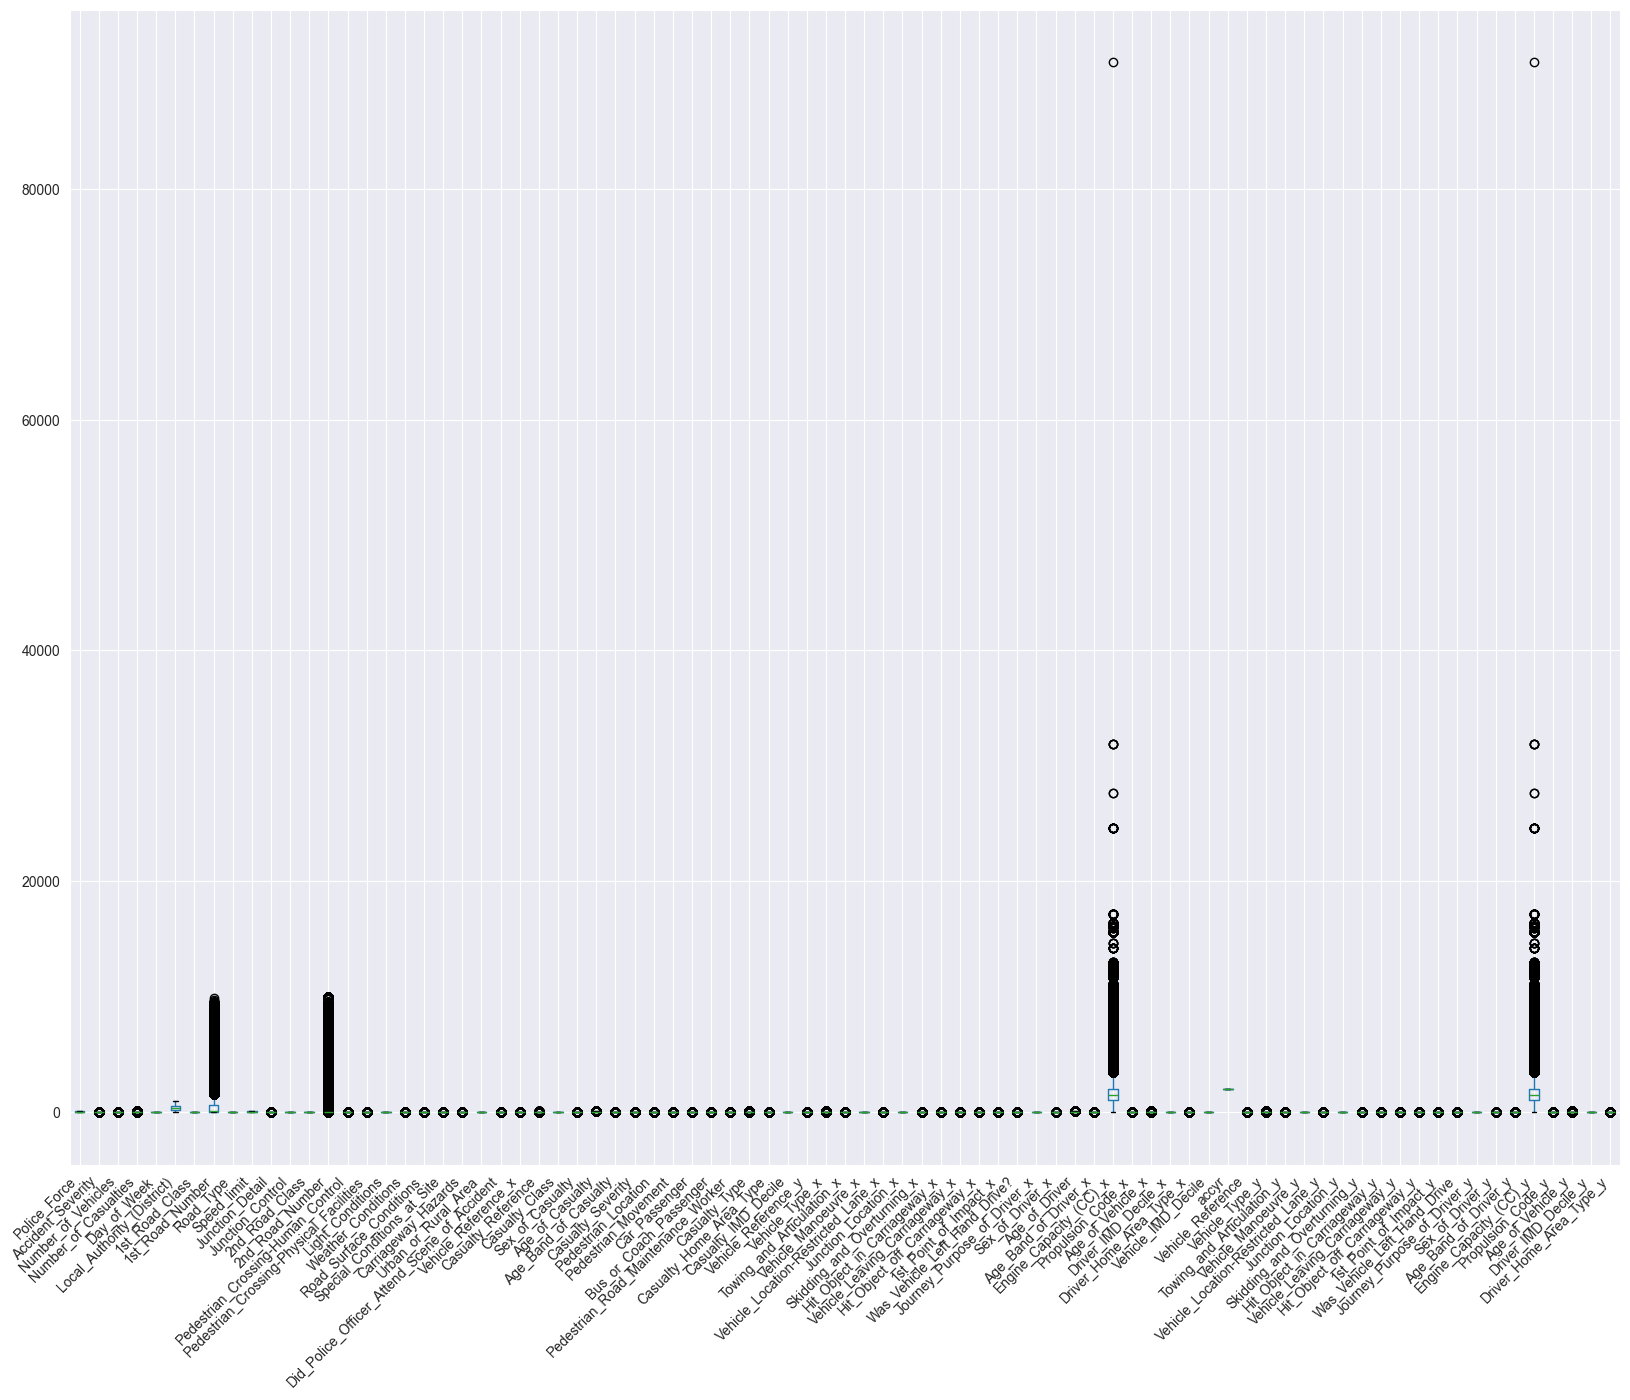

In [87]:
box = Data_no_geo.boxplot(figsize=(20,15))
plt.xticks(rotation=45, ha='right', fontsize=10)

Powyższy wykres pudełkowy pokazuje nam rozkład i rozproszenie danych dla poszczególnych cech. Można zauważyć wartości odstające dla następujących cech: 1st Road Number, 2nd Road Number, Vehicle Propulsion Code, Engine Capacity.

### Wykresy typu Boxplot

Text(0.5, 1.0, 'Distribution of features on road accident casualties')

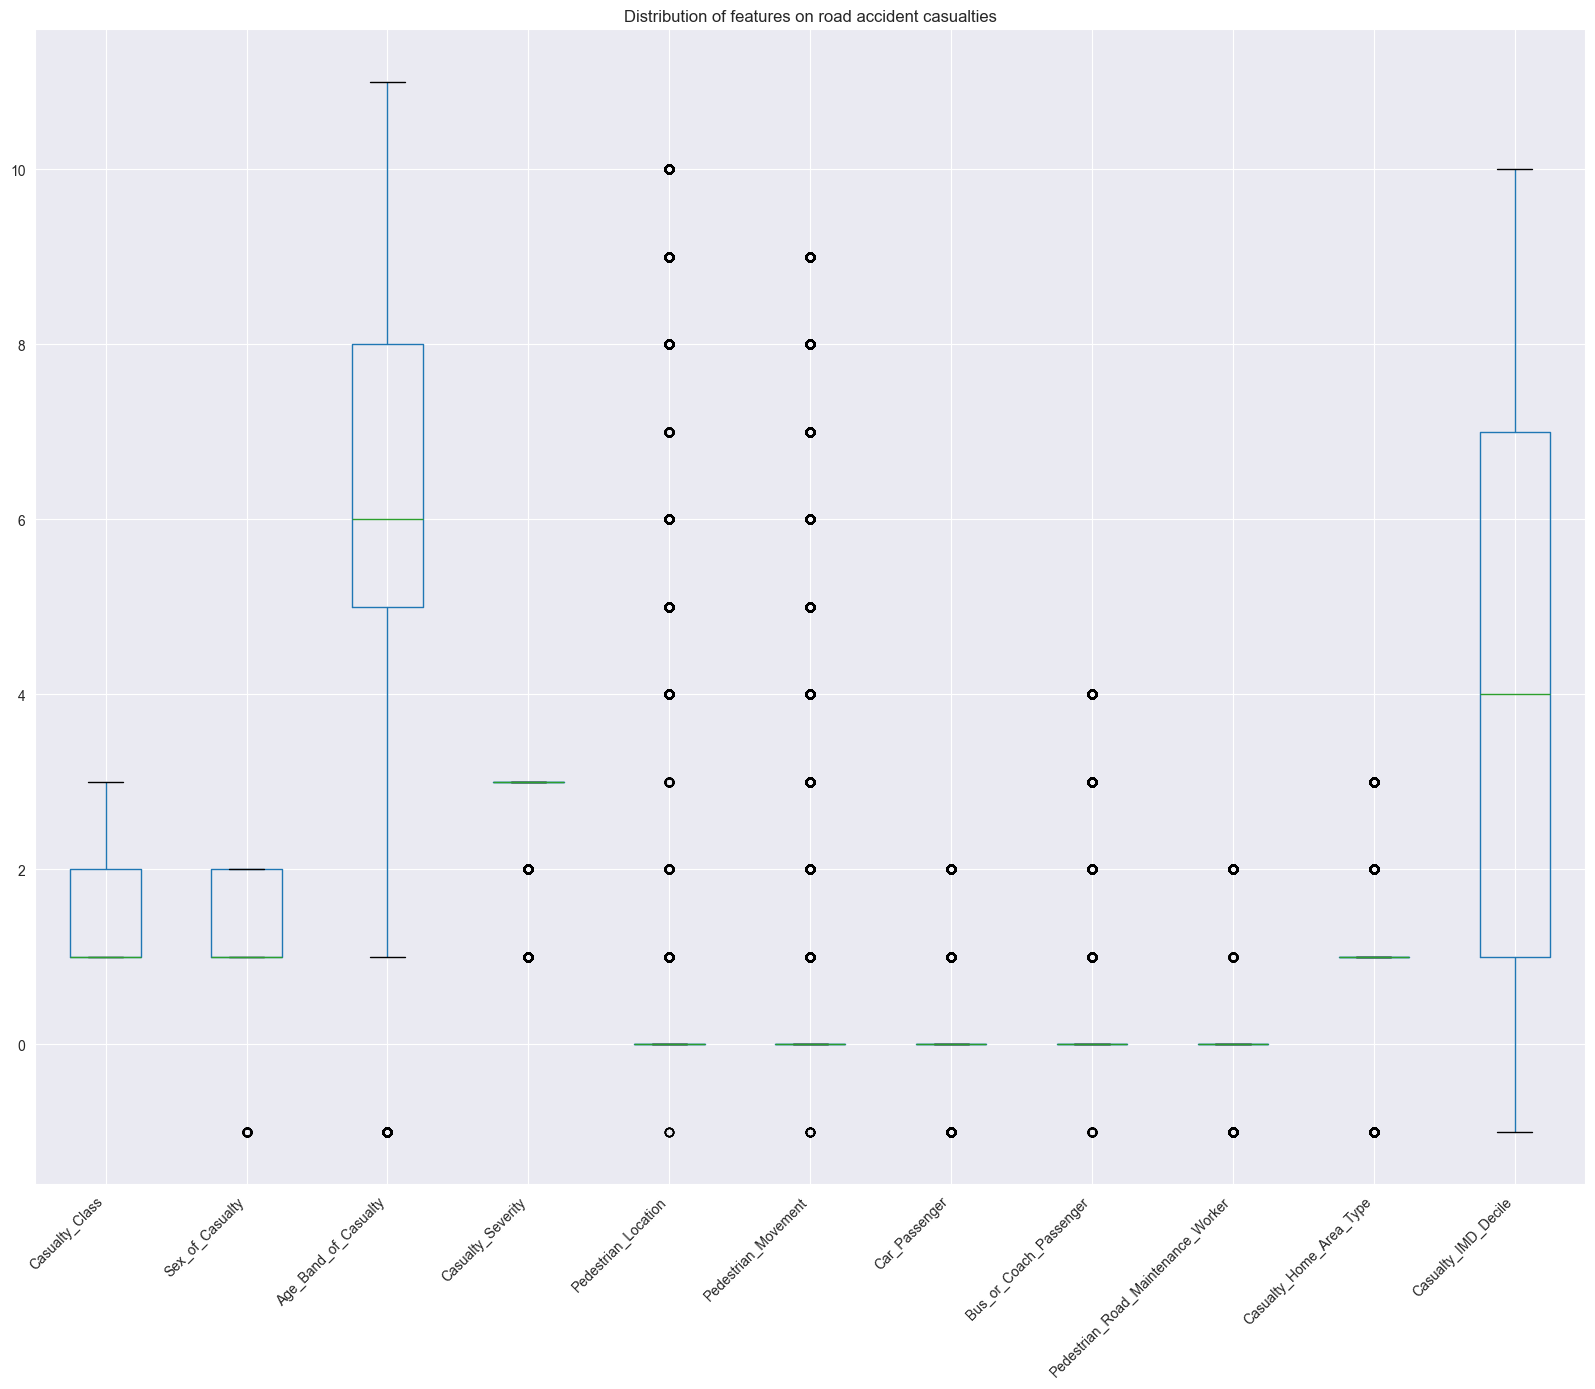

In [88]:
Casualties_uniform = Casualties.drop(['Vehicle_Reference', 'Casualty_Reference', 'Age_of_Casualty', 'Casualty_Type' ], axis=1)
Casualties_uniform.boxplot(figsize=(20,15))
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.title('Distribution of features on road accident casualties')

Rozpatrując wiek ofiar wypadków (Age_of_Casualty) można zauważyć, że mediana jest około połowy zakresu międzykwartylowego, z niektórymi wartościami odstającymi w górnej części zakresu. Dla klasy wypadków (Casualty_Class) można podkreślić, że większość danych koncentruje się w dolnej części zakresu międzykwartylowego, z niewielkim rozproszeniem i brakiem wartości odstających. Płeć ofiary wypadków (Sex_of_Casualty) może sugerować nam o niewielkiej różnice między mężczyznami a kobietami w kontekście wypadków drogowych, z podobnymi medianami dla obu grup. Na wykresie są widoczne dane odstające dla większości cech w tym dane brakujące oznaczone jako -1 za wyjątkiem klasy wypadków (Casualty_Class) oraz Casualty_IMD_Decile. 

Text(0.5, 1.0, 'Distribution of accident vehicle features')

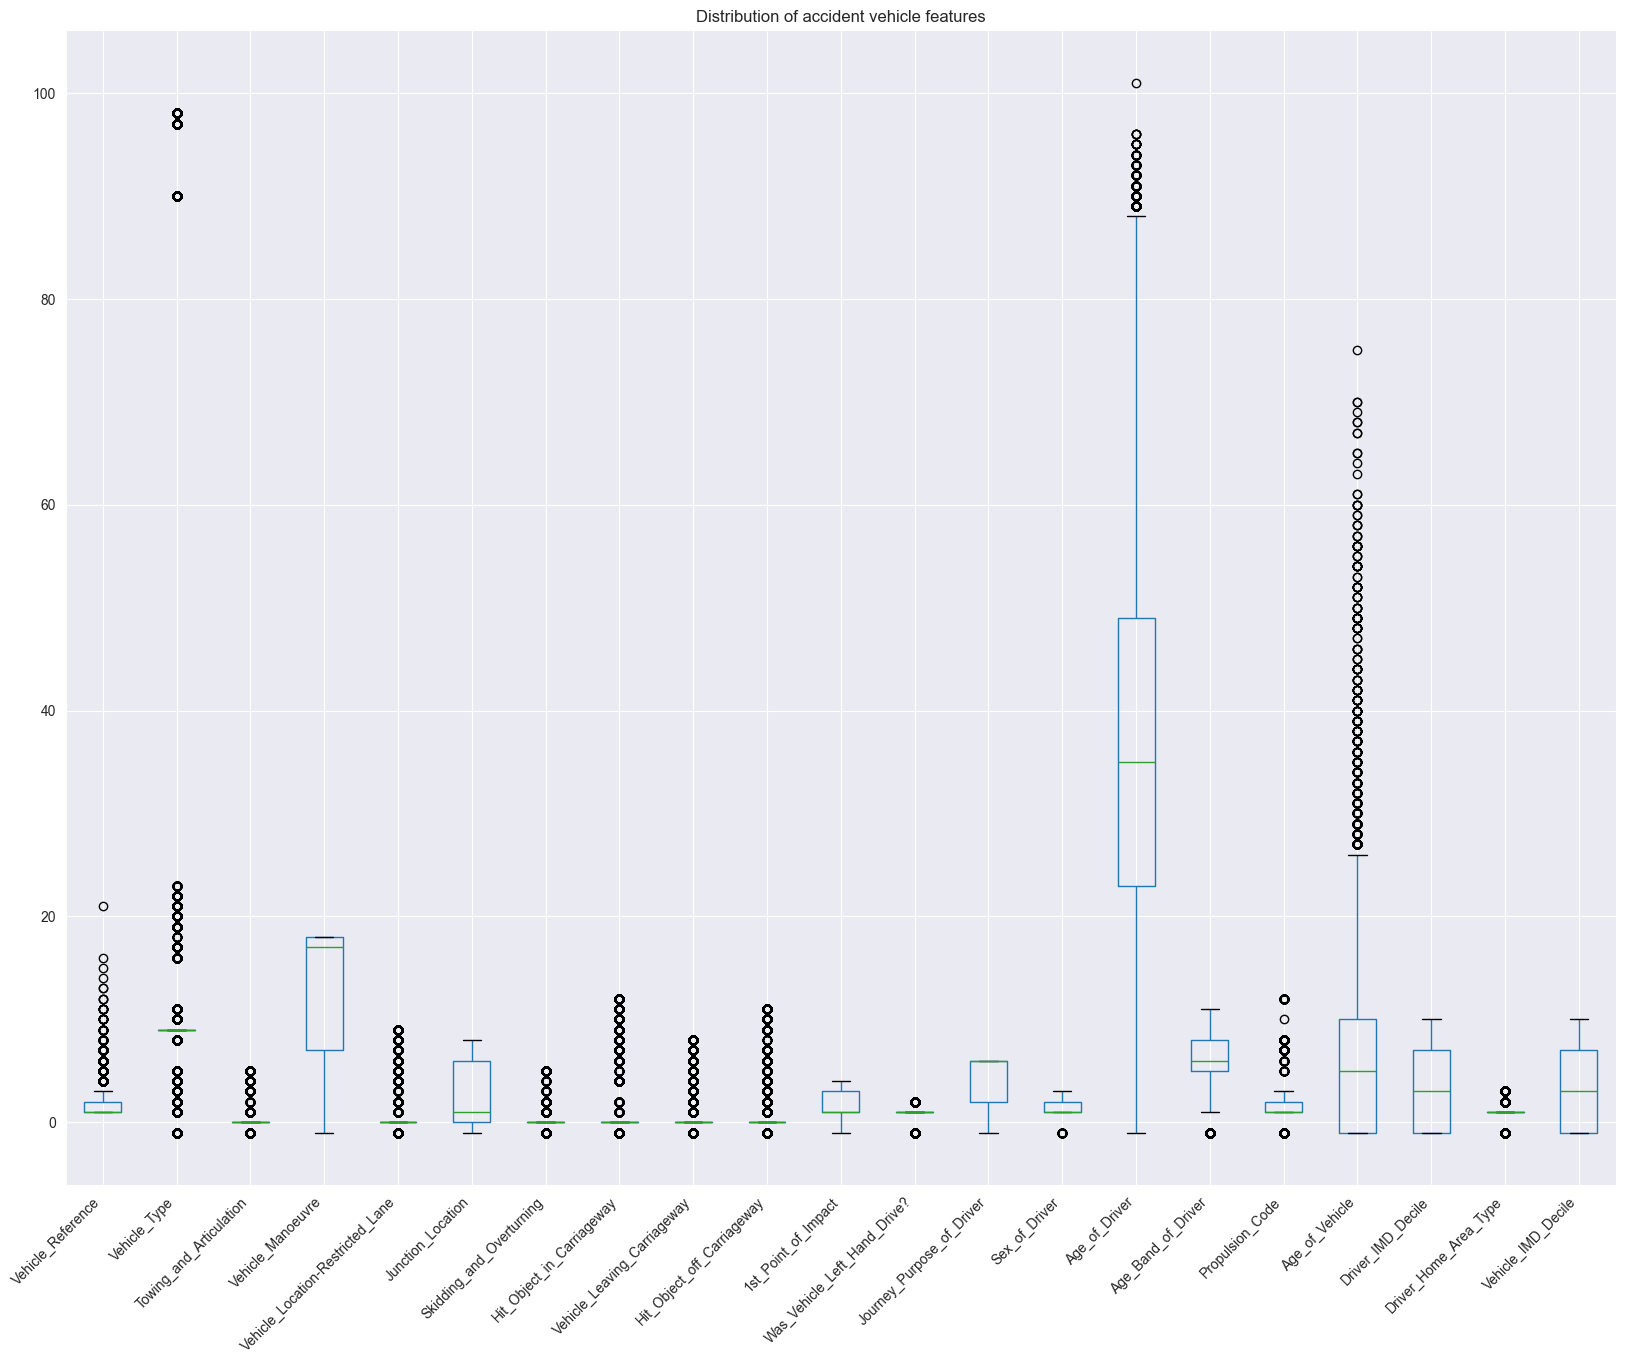

In [89]:
Vehicles_uniform = Vehicles.drop(['Engine_Capacity_(CC)'], axis=1)
Vehicles_uniform.boxplot(figsize=(20,15))
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.title('Distribution of accident vehicle features')

Rozpatrując wiek pojazdu (Age_of_Vehicle) może się wydawać że rozproszenie danych jest głównie w niższym wieku pojazdów, co sugeruje, że większość pojazdów wypadkowych jest stosunkowo młoda. Warto zwrócić uwagę na cechę 'Was_Vehicle_Left_Hand_Drive', gdzie większość danych jest skoncentrowana w określonej kategorii, co może wskazywać na przewagę określonego typu układu kierowniczego. Dla 'Vehicle_Type' można zauważyć znaczną różnorodność w rozproszeniu danych, co sugeruje, że wypadki dotykają różnych typów pojazdów w różnym stopniu. Cecha 'Towing_and_Articulation' wydaje się mieć niewielkie rozproszenie, co sugeruje, że większość danych koncentruje się wokół określonej kategorii lub kategorii. Na wykresie są widoczne dane odstające dla większości cech w tym dane brakujące oznaczone jako -1 za wyjątkiem Vehicle_Manoeuvre, Junction_Location, 1st_Point_of_Impact, Journey_Purpose_of_Driver, Driver_IMD_Decile oraz Vehicle_IMD_Decile.

Text(0.5, 1.0, 'Distribution of features about make model')

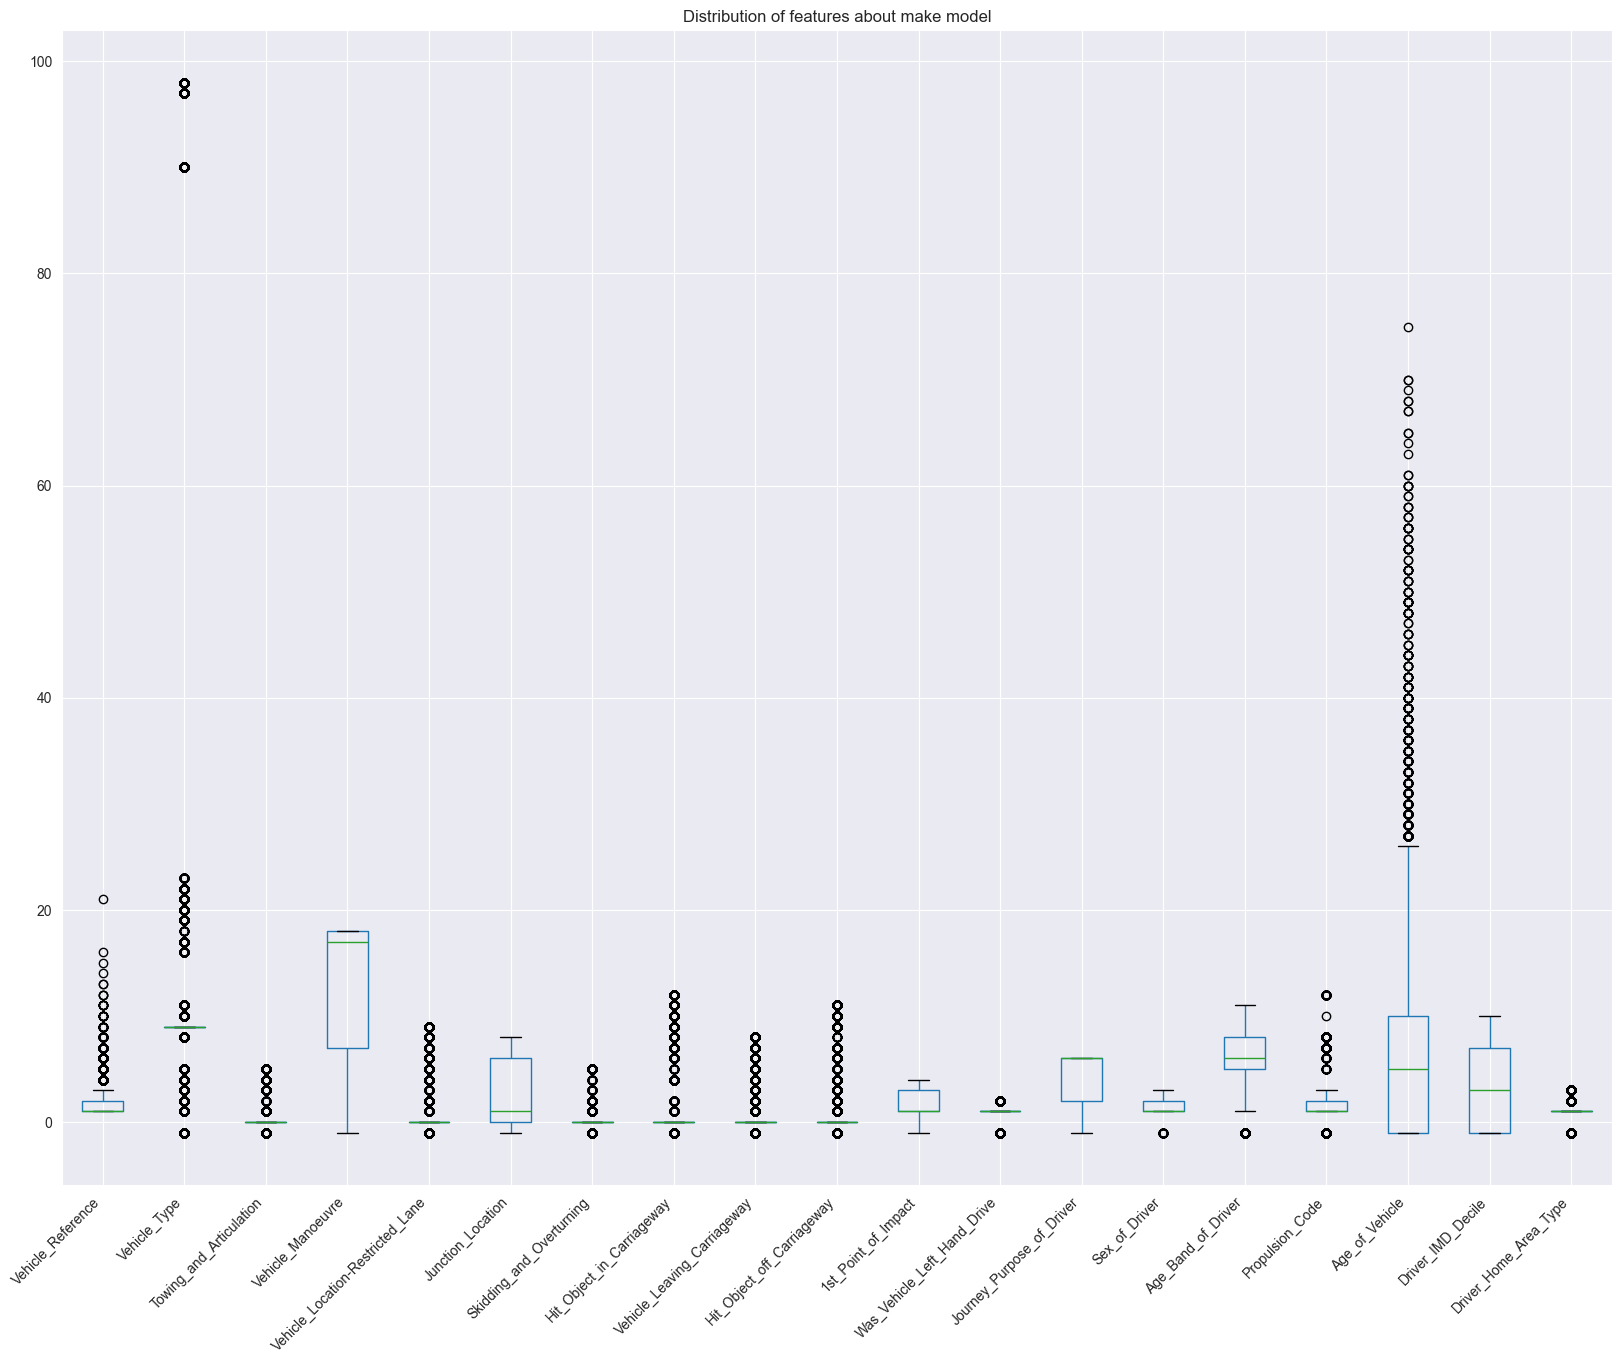

In [90]:
MakeModel_uniform = MakeModel.drop(['accyr', 'Engine_Capacity_(CC)'], axis=1)
MakeModel_uniform.boxplot(figsize=(20,15))
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.title('Distribution of features about make model')

Rozkład wieku pojazdów (Age_of_Vehicle) jest skoncentrowany w okolicach średniej wartości, co sugeruje, że większość pojazdów ma przeciętny wiek. Wartości Engine_Capacity_(CC) są rozproszone na całym zakresie, co wskazuje na różnorodność pojemności silnika w badanych pojazdach. Istnieje zauważalne rozproszenie wartości w różnych grupach wiekowych kierowców (Age_Band_of_Driver_y), co sugeruje, że wypadki występują w różnych grupach wiekowych. Na wykresie są widoczne dane odstające dla większości cech w tym dane brakujące oznaczone jako -1 za wyjątkiem Vehicle_Manoeuvre, Junction_Location, 1st_Point_of_Impact, Journey_Purpose_of_Driver, Driver_IMD_Decile oraz Vehicle_IMD_Decile.

Text(0.5, 1.0, 'Distribution of features on road accidents')

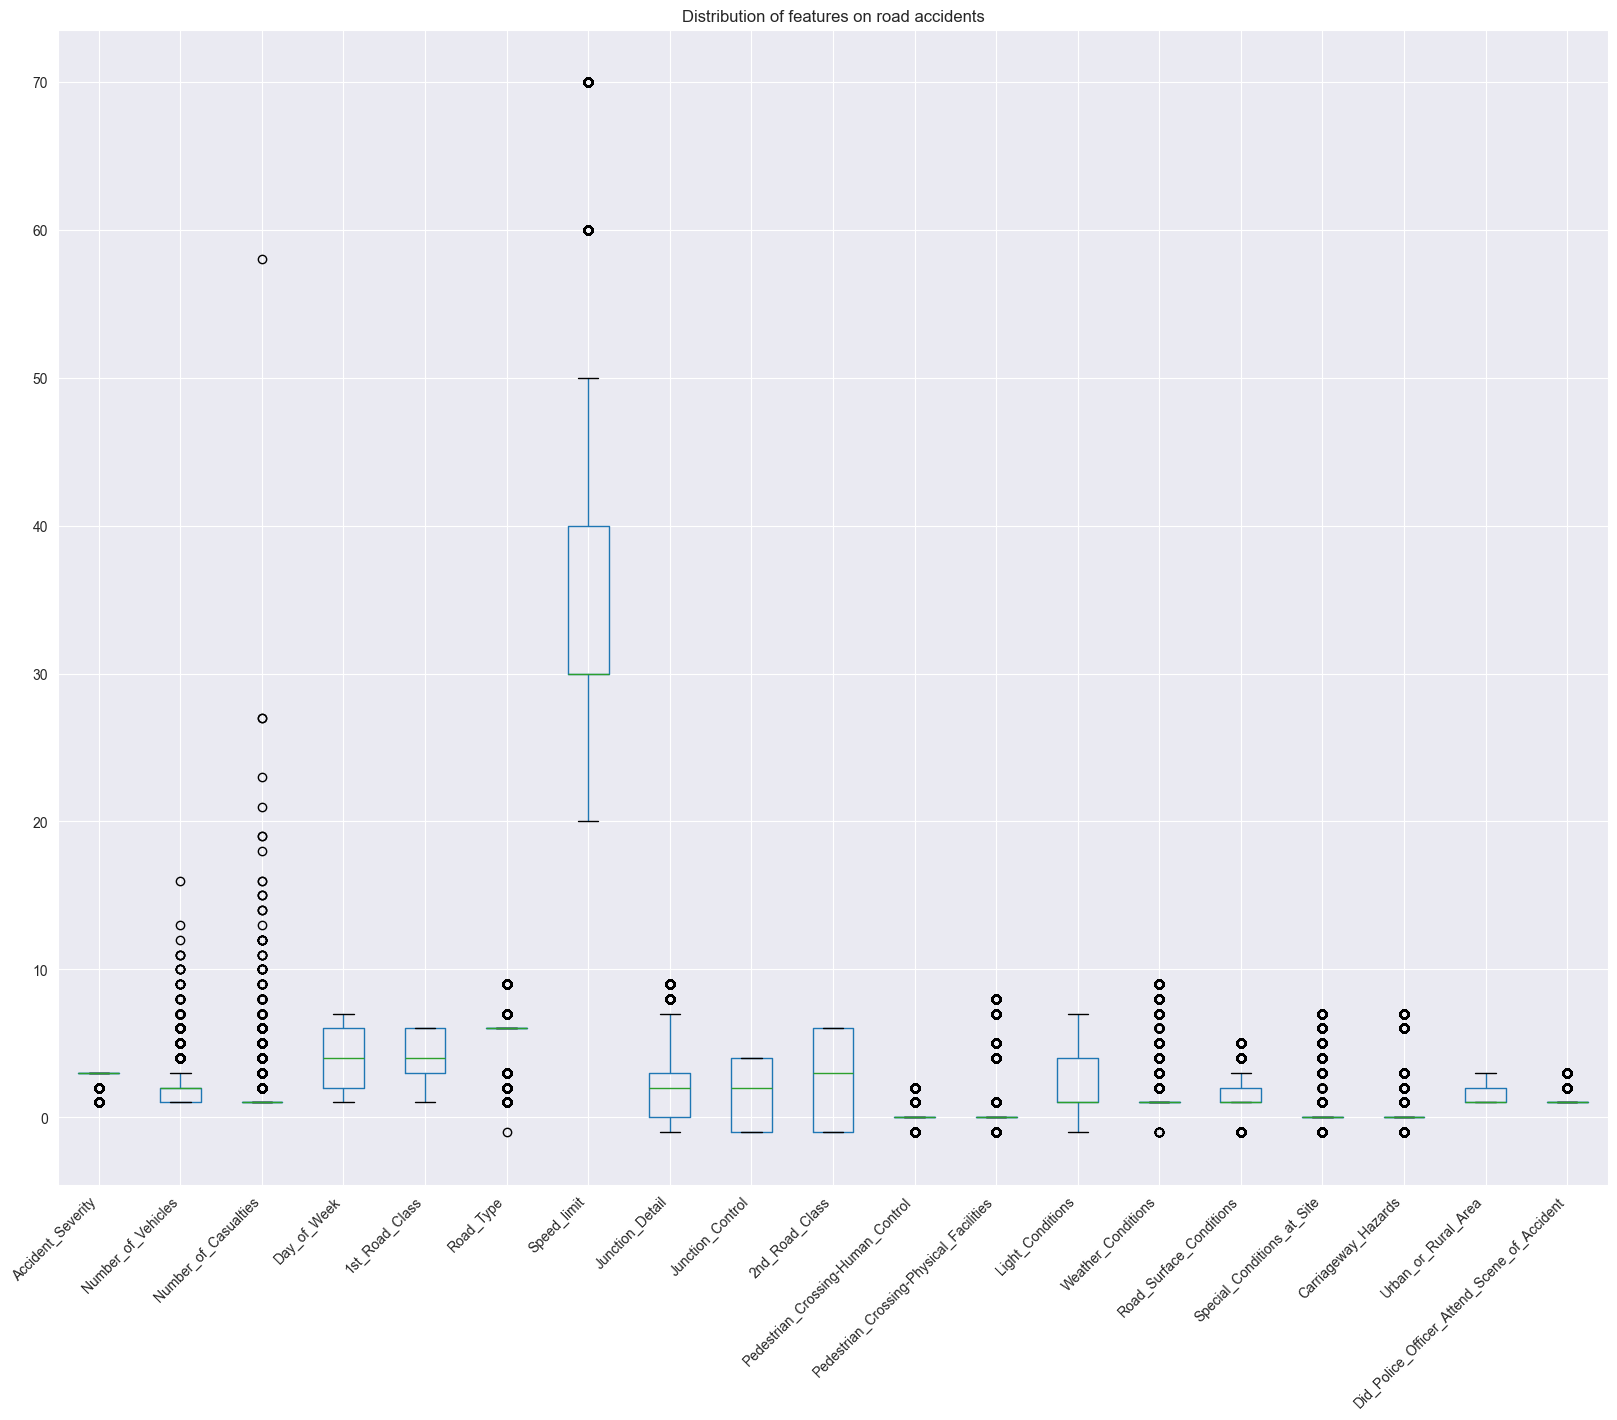

In [91]:
Accidents_uniform = Accidents.drop(['Location_Easting_OSGR', 'Location_Northing_OSGR', 'Longitude', 'Latitude', '1st_Road_Number', '2nd_Road_Number', 'Local_Authority_(District)', 'Police_Force'], axis=1)
Accidents_uniform.boxplot(figsize=(20,15))
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.title('Distribution of features on road accidents')

Widać, że większość wypadków miała niski poziom powagi (Accident_Severity), z czego można wywnioskować, że większość wypadków drogowych nie prowadziła do poważnych konsekwencji. Rozkład liczby pojazdów biorących udział w wypadkach (Number_of_Vehicles) jest skoncentrowany wokół niższych wartości, ale istnieją również pojedyncze przypadki z dużą liczbą pojazdów, co może wskazywać na zróżnicowanie sytuacji wypadków. Widać rozproszenie wartości liczby ofiar (Number_of_Casualties), co sugeruje, że wypadki mogą mieć różne skutki w postaci rannych lub zabitych osób.

### Wykresy dotyczące groźności wypadków

Zależność między liczbą ofiary wypadków, a ich groźnością jest jednym z najważniejszych parametrów analizy wypadków komunikacyjnych. Kluczowe jest zidentyfikowanie w jakich wypadkach dochodzi do najgroźniejszych obrażeń i pozwoli to na dalszą analizę pod kątem przyczyn takich zjawisk. Można dzięki nim wyodrębnić obszary, które wymagają poprawy, oraz zabezpieczyć tereny, które stawały się czarnymi punktami na mapach drogowych.
Poniżej przedstawione są histogramy liczności wypadków o konkrentym stopniu szkodliwości, oraz wykresy pudełkowe, prezentujące wyżej opisaną zależność. Takie wykresy mogą służyć jako wstęp do dalszej selekcji danych, które będą analizowane pod kątem przyczyn wypadków, oraz do lepszego podzielenia danych na zbiory testowe i treningowe.

<Axes: xlabel='Accident_Severity', ylabel='Number_of_Casualties'>

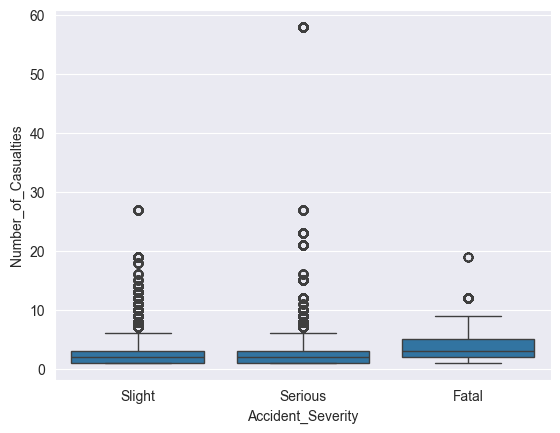

In [92]:
# Tworzenie opisów do legendy
Severity_legend = {
    1: 'Fatal',
    2: 'Serious',
    3: 'Slight'
}

# Podstawienie opisów do wartości
Comp_data['Accident_Severity'] = Comp_data['Accident_Severity'].map(Severity_legend)

sns.boxplot(x='Accident_Severity', y='Number_of_Casualties', data=Comp_data)

<Axes: xlabel='Accident_Severity', ylabel='count'>

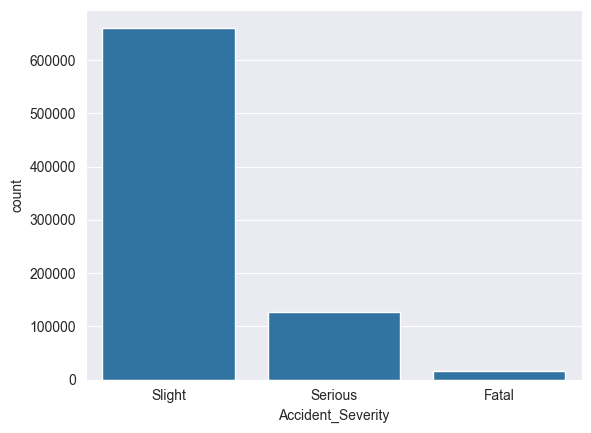

In [93]:
countplt = sns.countplot(x='Accident_Severity', data=Comp_data)
countplt

### Wyodrębnienie kolumny dotyczącej powodu podróży kierowcy

Lepsze zrozumienie powodów dla których kierowcy ruszają w drogę może pomóc zrozumieć np. dlaczego przekroczyli dozwolony limit prędkości, albo dlaczego wyprzedzali na podwójnej ciągłej.

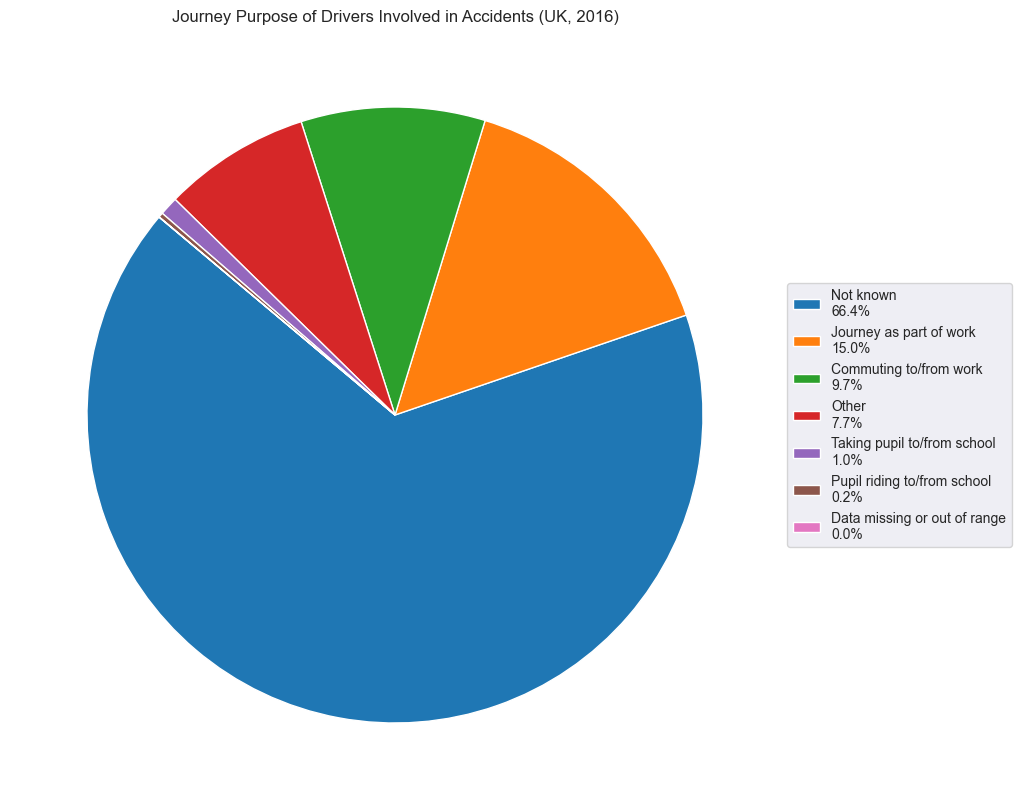

In [94]:
journey_purpose_counts = Data_no_geo['Journey_Purpose_of_Driver_y'].value_counts()

# Tworzenie opisów do legendy
journey_purpose_legend = {
    1: 'Journey as part of work',
    2: 'Commuting to/from work',
    3: 'Taking pupil to/from school',
    4: 'Pupil riding to/from school',
    5: 'Other',
    6: 'Not known',
    -1: 'Data missing or out of range'
}

# Podstawienie opisów do wartości
journey_purpose_counts.index = journey_purpose_counts.index.map(journey_purpose_legend)

plt.figure(figsize=(10, 10))
patches, texts, autotexts = plt.pie(journey_purpose_counts, startangle=140, autopct='', labels=None)

# Dodawanie ręcznie etykiet procentowych na zewnątrz koła
percent = journey_purpose_counts / journey_purpose_counts.sum() * 100
labels = [f'{label}\n{percentage:.1f}%' for label, percentage in zip(journey_purpose_counts.index, percent)]
plt.legend(patches, labels, loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('Journey Purpose of Drivers Involved in Accidents (UK, 2016)')
plt.show()

### Mapa wypadków drogowych w Wielkiej Brytanii

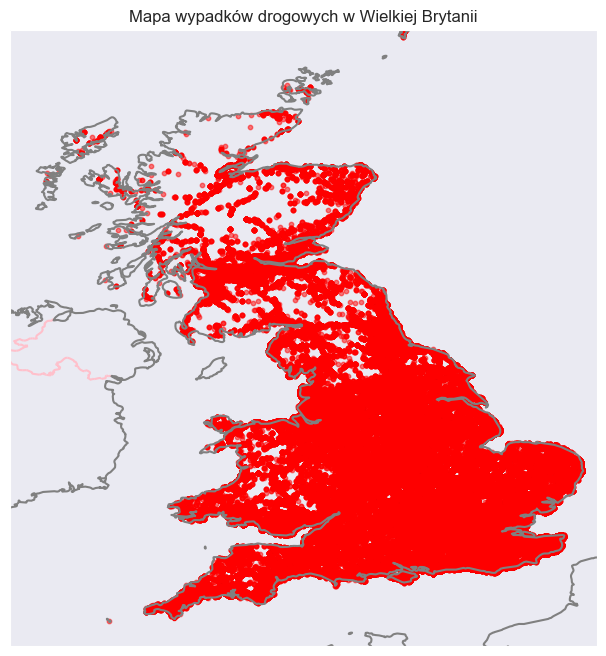

In [95]:
# Utworzenie wykresu mapy
plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-8, 2, 49.5, 60], crs=ccrs.PlateCarree())  # Ustawienie granic na Wielką Brytanię

# Dodanie warstwy granic kraju na różowo z wbudowanych danych
ax.add_feature(cfeature.BORDERS.with_scale('10m'), linewidth=1.5, edgecolor='pink')

# Dodanie warstwy granic Wielkiej Brytanii z wbudowanych danych
ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=1.5, edgecolor='gray')

# Dodanie punktów reprezentujących wypadki drogowe
ax.scatter(Comp_data['Longitude'], Comp_data['Latitude'], transform=ccrs.PlateCarree(), color='red', alpha=0.5, s=10)

plt.title('Mapa wypadków drogowych w Wielkiej Brytanii')
plt.show()

Ten wykres przedstawia mapę Wielkiej Brytanii z zaznaczonymi punktami reprezentującymi wypadki drogowe. Granice kraju są oznaczone różową linią, natomiast wybrzeże jest oznaczone szarą linią. Czerwone punkty na mapie reprezentują lokalizacje wypadków drogowych, gdzie każdy punkt symbolizuje jeden wypadek. Przezroczystość punktów została dostosowana, aby ułatwić zidentyfikowanie obszarów o większej gęstości wypadków. Całość ma na celu zobrazowanie rozkładu wypadków drogowych w Wielkiej Brytanii na tle geograficznych cech kraju.

### Wykres wypadków drogowych według marek samochodów

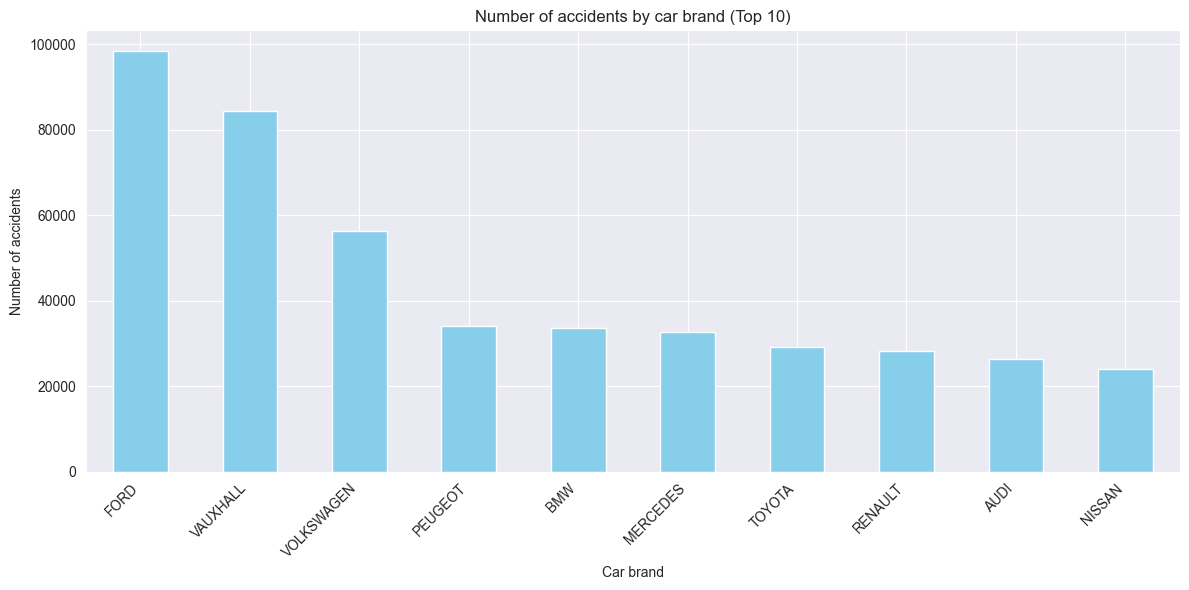

In [96]:
# Analiza liczby wypadków według marki pojazdu
wypadki_marka_auta = Data_no_geo.groupby('make')['Accident_Index'].count().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
wypadki_marka_auta.head(10).plot(kind='bar', color='skyblue')
plt.title('Number of accidents by car brand (Top 10)')
plt.xlabel('Car brand')
plt.ylabel('Number of accidents')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Marki FORD, VAUXHALL i VOLKSWAGEN zajmują czołowe miejsca pod względem liczby wypadków. Można wywnioskować, że pojazdy tych marek są częściej zaangażowane w wypadki drogowe niż pojazdy innych marek. Także to może sugerować, że pojazdy tych marek mogą być bardziej narażone na ryzyko wypadków lub że występujące w nich usterki lub błędy konstrukcyjne mogą przyczyniać się do większej liczby kolizji.

### Wykres kołowy wypadków drogowych według płci 

Liczba wypadków według płci:
Sex_of_Driver_y
Data missing       114
Male            520793
Female          231473
Unknown          52473
Name: Accident_Index, dtype: int64


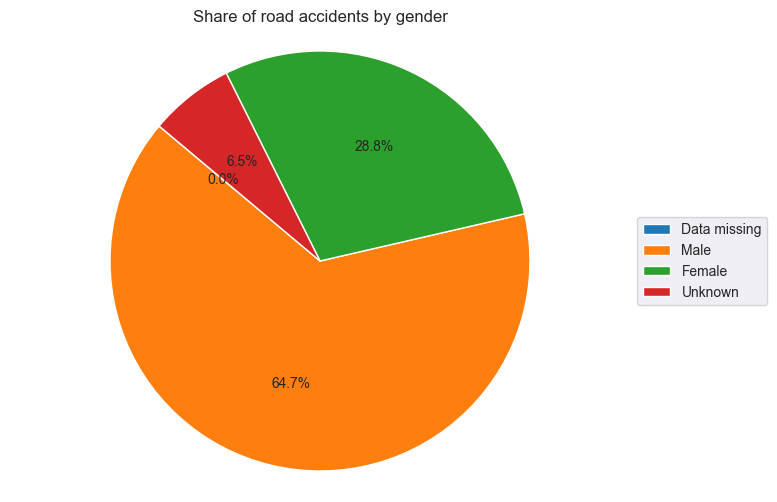

In [97]:
wypadki_plec_legend = {
    1: 'Male',
    2: 'Female',
    3: 'Unknown',
    -1: 'Data missing'
}

# Analiza wypadków według płci
wypadki_wedlug_plci = Data_no_geo.groupby('Sex_of_Driver_y')['Accident_Index'].count()

wypadki_wedlug_plci.index = wypadki_wedlug_plci.index.map(wypadki_plec_legend)

print("Liczba wypadków według płci:")
print(wypadki_wedlug_plci)

plt.figure(figsize=(8, 6))
plt.pie(wypadki_wedlug_plci, autopct='%1.1f%%', startangle=140)
plt.title('Share of road accidents by gender')
plt.axis('equal') 
plt.legend(labels=wypadki_wedlug_plci.index, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Na podstawie analizy liczby wypadków według płci można zauważyć, że większość wypadków drogowych (64.7%) dotyczy mężczyzn, podczas gdy udział kobiet w tych wypadkach wynosi 28.8%. Istnieje również kategoria o nieznanym lub nieokreślonym statusie płciowym, która stanowi 6.5% wszystkich wypadków. Ten wynik sugeruje, że mężczyźni są bardziej narażeni na wypadki drogowe niż kobiety. 

### Wykres słupkowy wypadków drogowych według wieku kierowców

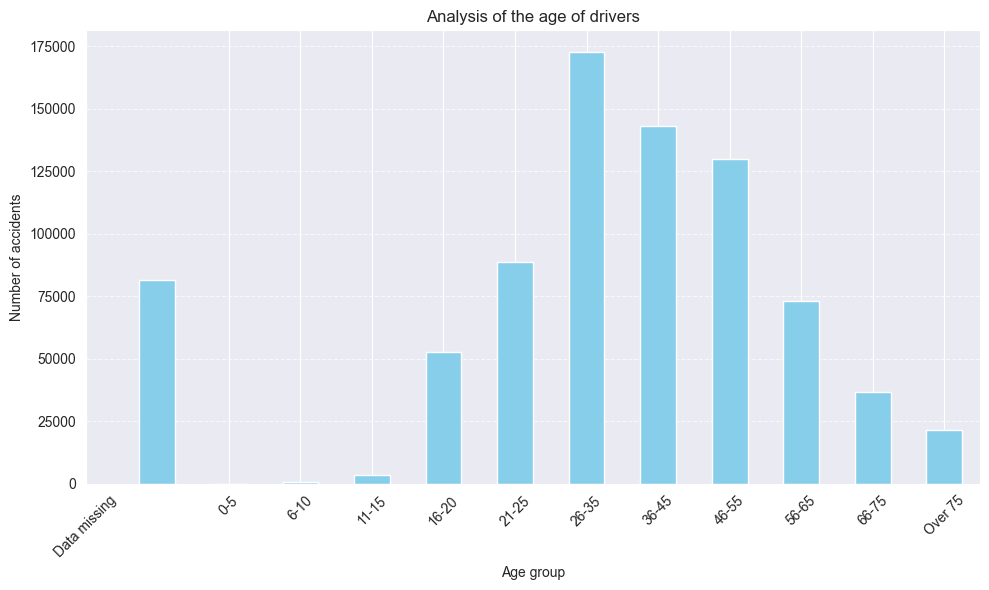

In [98]:
# Analiza wieku kierowców
analiza_wieku = Data_no_geo['Age_Band_of_Driver_y'].value_counts().sort_index()

etykiety = {
    '1': '0-5',
    '2': '6-10',
    '3': '11-15',
    '4': '16-20',
    '5': '21-25',
    '6': '26-35',
    '7': '36-45',
    '8': '46-55',
    '9': '56-65',
    '10': '66-75',
    '11': 'Over 75',
    '-1': 'Data missing'
}


# Tworzenie wykresu słupkowego z etykietami
plt.figure(figsize=(10, 6))
analiza_wieku.plot(kind='bar', color='skyblue')
plt.title('Analysis of the age of drivers')
plt.xlabel('Age group')
plt.ylabel('Number of accidents')
plt.xticks(rotation=45)
plt.xticks(analiza_wieku.index, [etykiety.get(str(x), 'Unknown') for x in analiza_wieku.index])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Te dane sugerują, że najczęściej w wypadkach drogowych uczestniczą osoby w wieku produkcyjnym. Trzy najbardziej narażone na wypadki grupy wiekowe to osoby w przedziałach wiekowych od 26 do 35 lat, od 36 do 45 lat oraz od 46 do 55 lat.

### Pairplot z wybranymi danymi

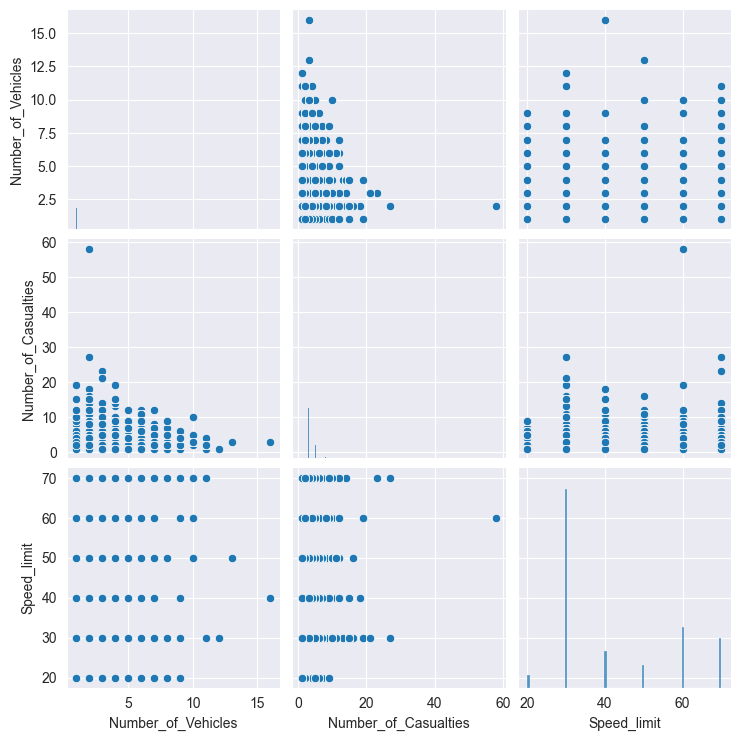

In [99]:
data_to_plot = Comp_data[['Number_of_Vehicles', 'Number_of_Casualties', 'Speed_limit']]

# Przeprowadzenie analizy pairplotów
sns.pairplot(data_to_plot)
plt.show()

W przypadku zmiennych Number_of_Vehicles i Number_of_Casualties, histogramy te sugerują, że większość wypadków ma niewielką liczbę pojazdów i ofiar. Natomiast histogram prędkości limitów sugeruje, że większość wypadków ma miejsce przy ograniczeniach prędkości na poziomie 30 lub 60 mil na godzinę. Wykresy punktowe pozwalają zauważyć potencjalne zależności między zmiennymi, takie jak np. tendencję wzrostową liczby ofiar wraz ze wzrostem liczby pojazdów. 

### Skalowanie
Pozwala na dostosowanie różnych cech w danych do podobnej skali, co ułatwia porównywanie ich i poprawia działanie algorytmów uczenia maszynowego.

#### MinMaxScaler
Jedna z popularnych technik skalowania danych, która przekształca cechy w zakres wartości od 0 do 1. Wartość minimalna każdej cechy jest przesunięta do 0, a wartość maksymalna jest przesunięta do 1, zachowując proporcje wartości między nimi.

In [100]:
features_to_scale = ['Number_of_Vehicles', 'Number_of_Casualties', 'Speed_limit']

scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(Comp_data[features_to_scale])

Comp_data_scaled = Comp_data.copy()
Comp_data_scaled[features_to_scale] = scaled_features

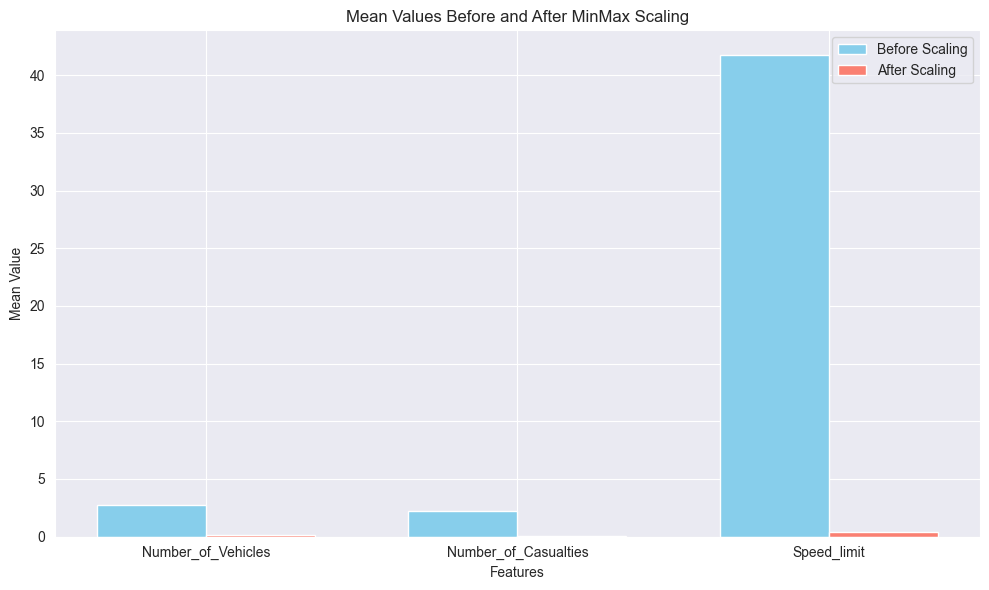

In [101]:
n_features = len(features_to_scale)

data_before_after_scal = np.zeros((2, n_features))

for i, feature in enumerate(features_to_scale):
    data_before_after_scal[0, i] = Comp_data[feature].mean()
    data_before_after_scal[1, i] = Comp_data_scaled[feature].mean()

plt.figure(figsize=(10, 6))
bar_width = 0.35
index = np.arange(n_features)

plt.bar(index, data_before_after_scal[0], bar_width, label='Before Scaling', color='skyblue')
plt.bar(index + bar_width, data_before_after_scal[1], bar_width, label='After Scaling', color='salmon')

plt.xlabel('Features')
plt.ylabel('Mean Value')
plt.title('Mean Values Before and After MinMax Scaling')
plt.xticks(index + bar_width / 2, features_to_scale)
plt.legend()

plt.tight_layout()
plt.show()

Powyższy wykres porównuje wymiary przed i po skalowaniu dla wybranych chech. Po skalowaniu jest widoczne, że wartości wahają się od 0 do 1. 

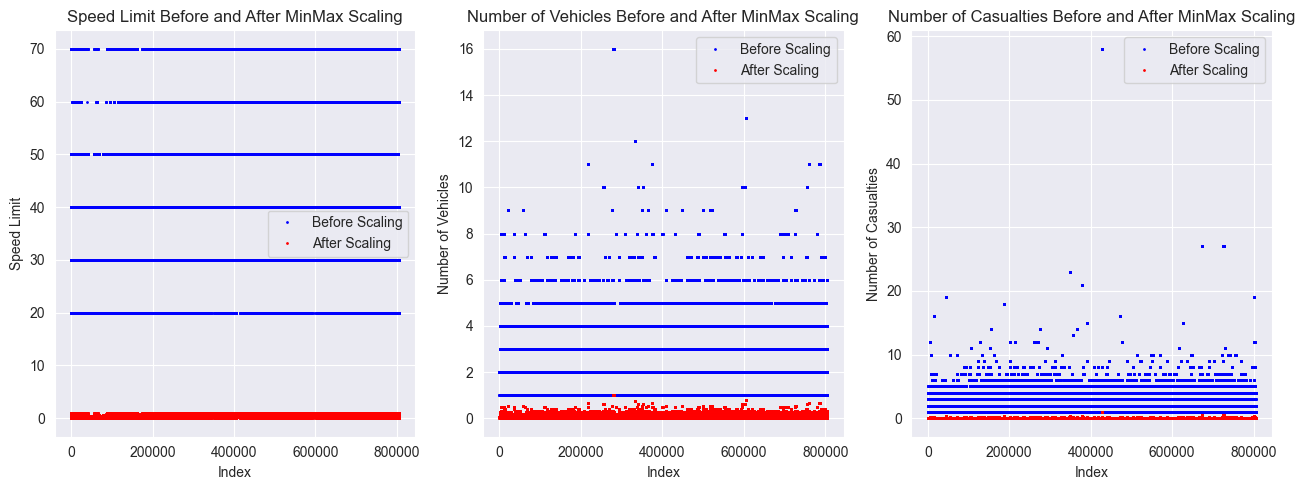

In [102]:
plt.figure(figsize=(13, 5))

plt.subplot(1, 3, 1)
plt.plot(Comp_data['Speed_limit'], 'bo', markersize=1, label='Before Scaling')
plt.plot(Comp_data_scaled['Speed_limit'], 'ro', markersize=1, label='After Scaling')
plt.title('Speed Limit Before and After MinMax Scaling')
plt.xlabel('Index')
plt.ylabel('Speed Limit')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(Comp_data['Number_of_Vehicles'], 'bo', markersize=1, label='Before Scaling')
plt.plot(Comp_data_scaled['Number_of_Vehicles'], 'ro', markersize=1, label='After Scaling')
plt.title('Number of Vehicles Before and After MinMax Scaling')
plt.xlabel('Index')
plt.ylabel('Number of Vehicles')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(Comp_data['Number_of_Casualties'], 'bo', markersize=1, label='Before Scaling')
plt.plot(Comp_data_scaled['Number_of_Casualties'], 'ro', markersize=1, label='After Scaling')
plt.title('Number of Casualties Before and After MinMax Scaling')
plt.xlabel('Index')
plt.ylabel('Number of Casualties')
plt.legend()

plt.tight_layout()
plt.show()

Na powyższych wykresach można wyraźnie zobaczyć, jak wartości mieszczą się w zakresie od 0 do 1 po skalowaniu i jak wyglądały przed skalowaniem.

#### StandardScaler
Inna popularna technika skalowania danych, która przekształca cechy tak, aby miały średnią równą 0 i odchylenie standardowe równą 1.

In [103]:
features_to_scale = ['Number_of_Vehicles', 'Number_of_Casualties', 'Speed_limit']

scaler_st = StandardScaler()
scaled_features_st = scaler_st.fit_transform(Comp_data[features_to_scale])

Comp_data_scaled_st = Comp_data.copy()
Comp_data_scaled_st[features_to_scale] = scaled_features_st

In [104]:
scaled_features_st

array([[-0.50383842, -0.59274785, -0.74636176],
       [-0.50383842, -0.59274785, -0.74636176],
       [-0.50383842, -0.59274785, -0.74636176],
       ...,
       [-1.20071962,  0.39698889, -0.11341436],
       [-1.20071962, -0.09787948,  1.78542784],
       [-1.20071962, -0.09787948,  1.78542784]])

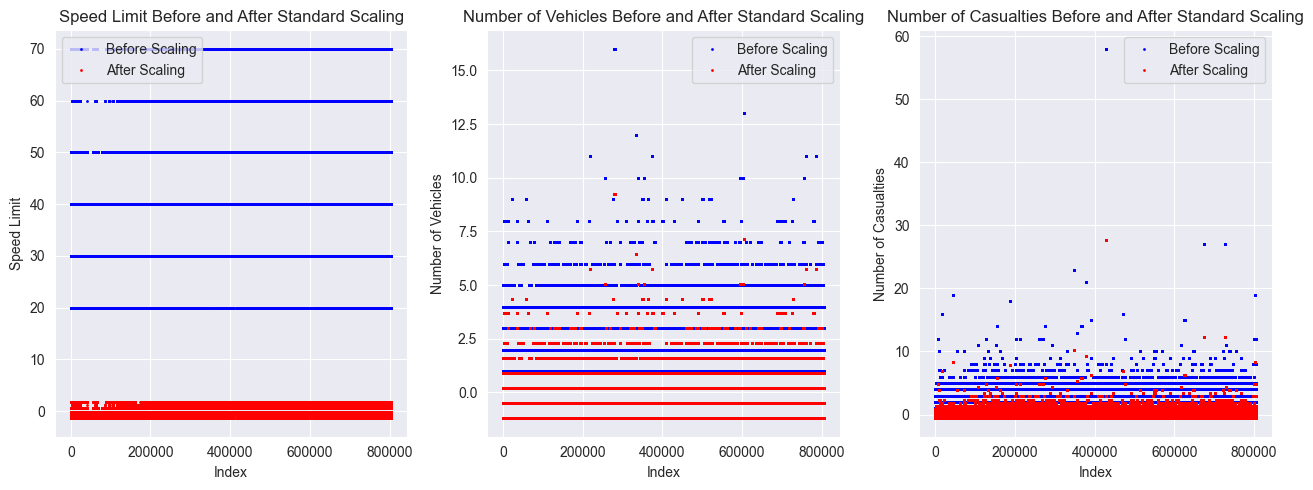

In [105]:
plt.figure(figsize=(13, 5))

plt.subplot(1, 3, 1)
plt.plot(Comp_data['Speed_limit'], 'bo', markersize=1, label='Before Scaling')
plt.plot(Comp_data_scaled_st['Speed_limit'], 'ro', markersize=1, label='After Scaling')
plt.title('Speed Limit Before and After Standard Scaling')
plt.xlabel('Index')
plt.ylabel('Speed Limit')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(Comp_data['Number_of_Vehicles'], 'bo', markersize=1, label='Before Scaling')
plt.plot(Comp_data_scaled_st['Number_of_Vehicles'], 'ro', markersize=1, label='After Scaling')
plt.title('Number of Vehicles Before and After Standard Scaling')
plt.xlabel('Index')
plt.ylabel('Number of Vehicles')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(Comp_data['Number_of_Casualties'], 'bo', markersize=1, label='Before Scaling')
plt.plot(Comp_data_scaled_st['Number_of_Casualties'], 'ro', markersize=1, label='After Scaling')
plt.title('Number of Casualties Before and After Standard Scaling')
plt.xlabel('Index')
plt.ylabel('Number of Casualties')
plt.legend()

plt.tight_layout()
plt.show()


Na wykresach przedstawiających dane przed i po skalowaniu standardowym można zauważyć, że po skalowaniu wartości cech mają średnią bliską zeru. Skalowanie standardowe umożliwia sprowadzenie wartości cech do wspólnego zakresu, co może poprawić wydajność algorytmów uczenia maszynowego, które są wrażliwe na różnice w skali cech. Dzięki temu można uniknąć przewagi jednej cechy nad innymi ze względu na jej większą skalę.

### Macierz korelacji
Macierz korelacji przedstawiona na wykresie ciepła pokazuje, w jakim stopniu zmienne są skorelowane ze sobą. Im ciemniejszy kolor, tym większa korelacja. W analizie danych dotyczących pojazdów możemy zauważyć, że niektóre zmienne mają silną korelację dodatnią, co oznacza, że zmieniają się one w tym samym kierunku. Natomiast brak korelacji między niektórymi zmiennymi może wskazywać na ich niezależność od siebie w kontekście analizowanych danych. 

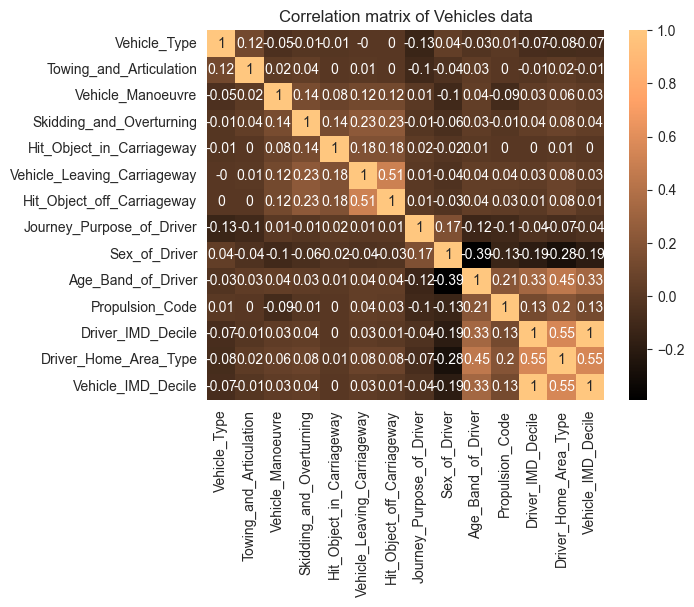

In [106]:
Veh_float = Vehicles.drop(['Accident_Index', 'Vehicle_Reference', 'Age_of_Driver', 'Engine_Capacity_(CC)', 'Age_of_Vehicle', '1st_Point_of_Impact', 'Vehicle_Location-Restricted_Lane', 'Junction_Location', 'Was_Vehicle_Left_Hand_Drive?'], axis=1)
Vehicle_corr = Veh_float.corr().round(2)
sns.heatmap(Vehicle_corr, annot=True, cmap='copper')
plt.title('Correlation matrix of Vehicles data')
plt.show()

Na przykład zmienna "Age_Band_of_Driver" wydaje się być silnie skorelowana z "Age_Band_of_Driver_y", co może sugerować spójność w sposobie zbierania tych danych lub istnienie pewnych wzorców wiekowych wśród kierowców różnych marek samochodów. Korelację można znaleźć między 

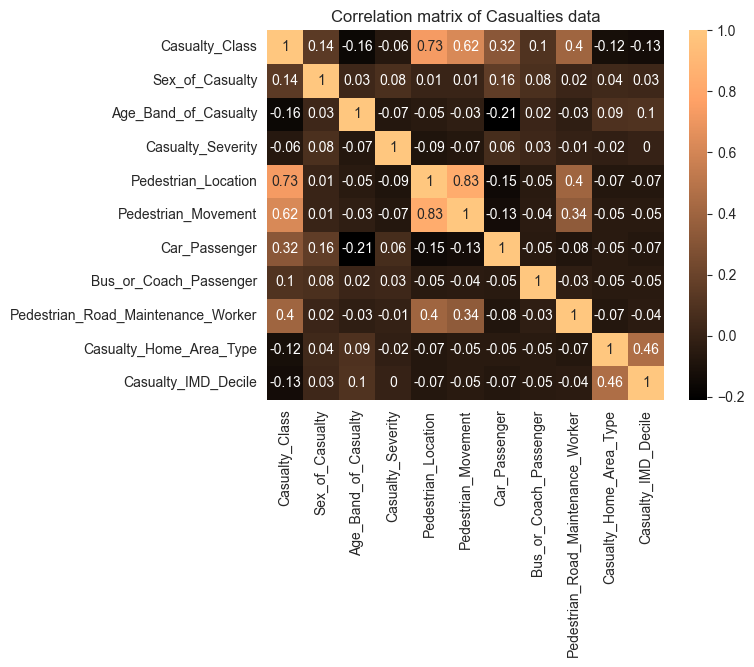

In [107]:
Cas_float = Casualties.drop(['Accident_Index', 'Vehicle_Reference', 'Casualty_Reference', 'Age_of_Casualty', 'Casualty_Type'], axis=1)
Casualty_corr = Cas_float.corr().round(2)
sns.heatmap(Casualty_corr, annot=True, cmap='copper')
plt.title('Correlation matrix of Casualties data')
plt.show()

Na podstawie wykresu korelacji widzimy korelację dodatnią o wartości 0.83 między "Pedestrian_Location" a "Pedestrian_Movement" sugeruje, że lokalizacja pieszych w stosunku do drogi jest mocno związana z ich ruchem w momencie wypadku. Natomiast korelację między "Casualty_Class" a "Pedestrian_Location" o wartości 0.73 wskazuje na związek między klasą ofiary (np. pieszy, kierowca) a jej lokalizacją w momencie wypadku. Te wyniki sugerują, że miejsce i sposób poruszania się pieszych mogą mieć istotny wpływ na rodzaj obrażeń w wypadkach drogowych.

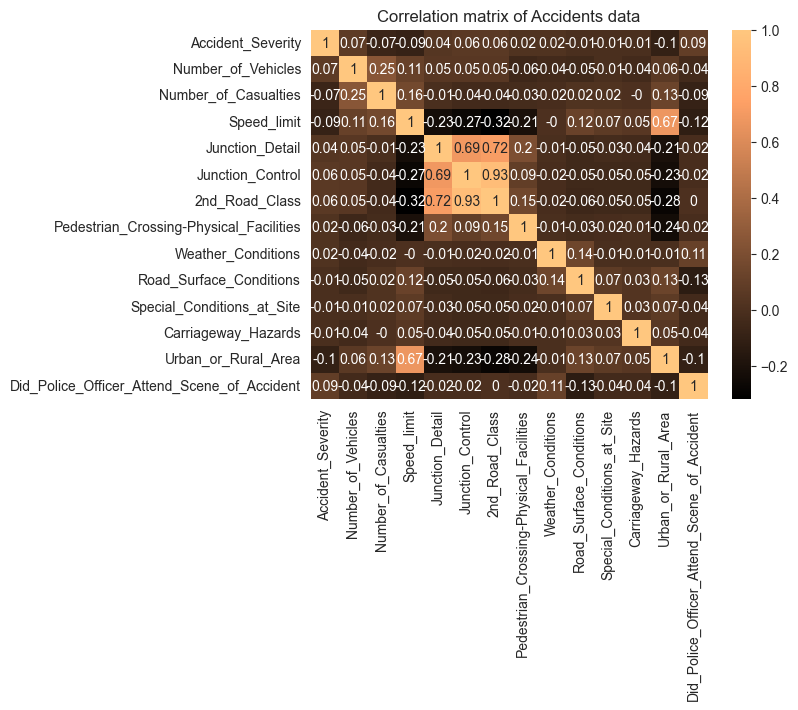

In [108]:
Acc_float = Accidents.drop(['Accident_Index', 'Location_Easting_OSGR', 'Location_Northing_OSGR', 'Longitude', 'Latitude', 'Local_Authority_(District)', 'Police_Force', 'Date', 'Time', 'Local_Authority_(Highway)', 'LSOA_of_Accident_Location','1st_Road_Number', '2nd_Road_Number', '1st_Road_Class', 'Day_of_Week', 'Road_Type', 'Pedestrian_Crossing-Human_Control', 'Light_Conditions'], axis=1)
Accident_corr = Acc_float.corr().round(2)
sns.heatmap(Accident_corr, annot=True, cmap='copper')
plt.title('Correlation matrix of Accidents data')
plt.show()


Na podstawie wykresu korelacji dla danych dotyczących wypadków drogowych widzimy kilka interesujących zależności. Na przykład, mamy silną korelację dodatnią 0.67 między prędkością limitu drogowego a rodzaj miejscowości, w której miał miejsce wypadek drogowy (Urban or Rural area) co może sugerować, że wypadki na obszarach miejskich lub wiejskich mogą różnić się ze względu na prędkość. Ponadto, korelacja między szczegółami skrzyżowania (junction_detail) a kontrolą skrzyżowania (junction_control) oraz 2nd_Road_Class sugeruje pewne wzajemne powiązania między tymi czynnikami, co może być istotne dla zrozumienia mechanizmu wypadków drogowych. Korelacja o wartości 0.69 między junction_detail a junction_control. Korelacja o wartości 0.72 między junction_detail a 2nd road class.Co do liczby ofiar (number_of_casualities) i liczby pojazdów (number_of_vihicles), to umiarkowana korelacja o wartości 0.25 sugeruje, że większa liczba pojazdów może prowadzić do większej liczby ofiar, co jest intuicyjne, ale potwierdza to analiza danych.

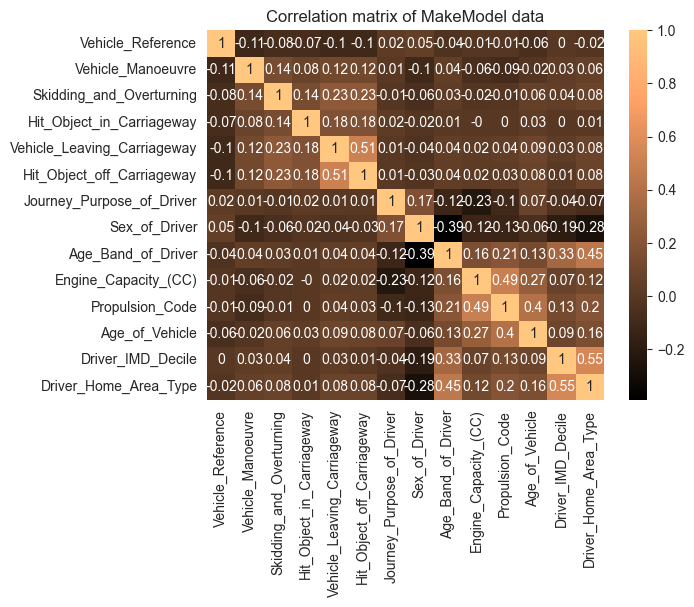

In [109]:
MakeModel_float = MakeModel.drop(['Accident_Index', 'accyr', 'model', 'make', 'Vehicle_Location-Restricted_Lane', 'Vehicle_Type', 'Junction_Location', '1st_Point_of_Impact', 'Was_Vehicle_Left_Hand_Drive', 'Towing_and_Articulation'], axis=1)
MakeModel_corr = MakeModel_float.corr().round(2)
sns.heatmap(MakeModel_corr, annot=True, cmap='copper')
plt.title('Correlation matrix of MakeModel data')
plt.show()

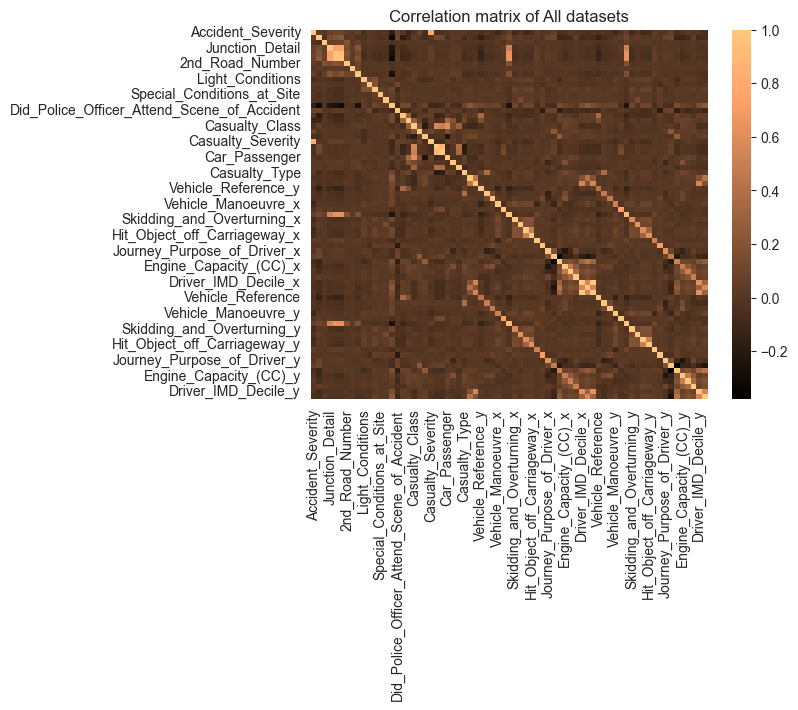

In [110]:
Data_no_geo_float = Data_no_geo.drop(['Accident_Index', 'Number_of_Vehicles', 'Number_of_Casualties', 'Speed_limit', 'Age_of_Driver', 'Age_of_Casualty', 'Day_of_Week', 'Road_Type', 'Time', 'Date', 'Local_Authority_(District)', 'Police_Force', 'Date', 'Time', 'Local_Authority_(Highway)', 'LSOA_of_Accident_Location', 'make', 'model', 'accyr'], axis=1)
Data_no_geo_corr = Data_no_geo_float.corr().round(2)
sns.heatmap(Data_no_geo_corr, cmap='copper')
plt.title('Correlation matrix of All datasets')
plt.show()


Macierz korelacji wszystkich zestawów danych pozwala na zrozumienie wzajemnych związków między różnymi zmiennymi w danych. Poprzez analizę korelacji można odkryć, które zmienne są ze sobą powiązane i w jaki sposób. To z kolei może pomóc w identyfikacji kluczowych czynników wpływających na badane zjawiska oraz w wyborze odpowiednich zmiennych do dalszej analizy i modelowania.

Poniżej znajduje się macierz korelacji dla wybranych cech.

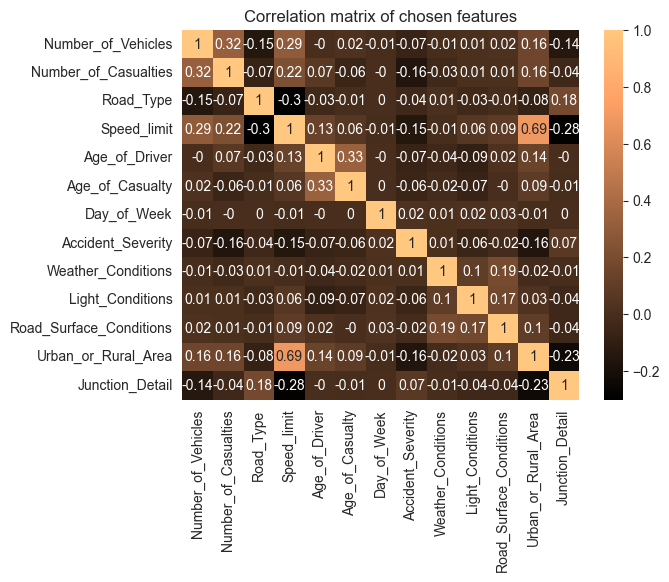

In [111]:
selected_features = ['Number_of_Vehicles', 'Number_of_Casualties', 'Road_Type', 'Speed_limit', 'Age_of_Driver', 'Age_of_Casualty', 'Day_of_Week', 'Accident_Severity', 'Weather_Conditions', 'Light_Conditions', 'Road_Surface_Conditions', 'Urban_or_Rural_Area', 'Junction_Detail']
features_subset = Data_no_geo[selected_features]
features_subset_corr = features_subset.corr().round(2)
sns.heatmap(features_subset_corr, annot=True, cmap='copper')
plt.title('Correlation matrix of chosen features')
plt.show()

Analiza korelacji między wybranymi cechami i zmienną "Accident_Severity" może pomóc zidentyfikować istotne zmienne dla modelu klasyfikacji. Na podstawie wyników:
* Istnieje umiarkowana dodatnia korelacja między "Number_of_Vehicles" a "Number_of_Casualties" (0.32), co sugeruje, że wypadki z większą liczbą pojazdów mogą częściej powodować większą liczbę ofiar.
* "Speed_limit" wykazuje umiarkowaną dodatnią korelację z "Number_of_Vehicles" (0.29) i "Number_of_Casualties" (0.22), co sugeruje, że większe limity prędkości mogą być związane z większą liczbą pojazdów i ofiar.
* "Age_of_Casualty" ma silną ujemną korelację z "Age_of_Driver" (-0.33), co wskazuje na to, że starsi kierowcy mogą być bardziej narażeni na wypadki z udziałem starszych osób.
* Korelacja między "Weather_Conditions" a "Road_Type" (0.01) jest niska, co sugeruje, że warunki pogodowe mogą mieć niewielki wpływ na rodzaj drogi, na której występują wypadki.
* "Light_Conditions" wykazuje niewielką dodatnią korelację z "Road_Surface_Conditions" (0.17), co sugeruje, że gorsze warunki oświetleniowe mogą być powiązane z gorszym stanem nawierzchni drogi.


Te obserwacje mogą być użyteczne podczas budowania modelu klasyfikacji, aby wybrać istotne cechy dla przewidywania powagi wypadków.

## Część 2 - Trenowanie modelu

### Podział danych na zbiory treningowe i testowe

In [112]:
def train_test_split(X, y, test_size=0.2, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)

    n_samples = len(X)
    shuffled_indices = np.random.permutation(n_samples)

    n_test = int(n_samples * test_size)

    test_indices = shuffled_indices[:n_test]
    train_indices = shuffled_indices[n_test:]

    X_train = X[train_indices]
    X_test = X[test_indices]
    y_train = y[train_indices]
    y_test = y[test_indices]

    return X_train, X_test, y_train, y_test


def accuracy(y_true, y_pred):
    total_TP = total_TN = total_FP = total_FN = 0
    unique_classes = np.unique(y_true)
    
    for class_label in unique_classes:
        TP = np.sum((y_true == class_label) & (y_pred == class_label))
        TN = np.sum((y_true != class_label) & (y_pred != class_label))
        FP = np.sum((y_true != class_label) & (y_pred == class_label))
        FN = np.sum((y_true == class_label) & (y_pred != class_label))
        
        total_TP += TP
        total_TN += TN
        total_FP += FP
        total_FN += FN

    accuracy = (total_TP + total_TN) / (total_TP + total_TN + total_FP + total_FN)
    return accuracy


def score_f1(y_true, y_pred):
    classes = set(y_true)
    f1_scores = []
    for c in classes:
        TP = np.sum((y_true == c) & (y_pred == c))
        FP = np.sum((y_true != c) & (y_pred == c))
        FN = np.sum((y_true == c) & (y_pred != c))
        precision = TP / (TP + FP) if TP + FP > 0 else 0
        recall = TP / (TP + FN) if TP + FN > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0
        f1_scores.append(f1)
    return np.mean(f1_scores)


def precision(y_true, y_pred):
    classes = np.unique(y_true)
    precisions = []
    for c in classes:
        TP = np.sum((y_true == c) & (y_pred == c))
        FP = np.sum((y_true != c) & (y_pred == c))
        precision = TP / (TP + FP) if TP + FP > 0 else 0
        precisions.append(precision)
    return np.mean(precisions)


def recall(y_true, y_pred):
    classes = np.unique(y_true)
    recalls = []
    for c in classes:
        TP = np.sum((y_true == c) & (y_pred == c))
        FN = np.sum((y_true == c) & (y_pred != c))
        recall = TP / (TP + FN) if TP + FN > 0 else 0
        recalls.append(recall)
    return np.mean(recalls)


#Data_no_geo_clean = Data_no_geo
# Data_no_geo_clean.fillna(Data_no_geo.mean(), inplace=True)

#X_array = Data_no_geo_clean.drop('Accident_Severity', axis=1).values
#y_array = Data_no_geo_clean['Accident_Severity'].values

Sel_data = features_subset.copy()
Sel_data.fillna(Sel_data.mean(), inplace=True)

X_array = Sel_data.drop('Accident_Severity', axis=1).values
y_array = Sel_data['Accident_Severity'].values

X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(X_array, y_array, test_size=0.2, random_state=42)

In [113]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def calculate_accuracy(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    return accuracy

def calculate_metrics(y_true, y_pred):
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    return precision, recall, f1

### Trening modelu klasyfikacji na sześć różnych metod 

#### Random Forest

In [114]:
Start_rand = time.time()
RandomForestClassifier_model = RandomForestClassifier(random_state=17)
RandomForestClassifier_model.fit(X_train_data, y_train_data)
RandomForestClassifier_predictions = RandomForestClassifier_model.predict(X_test_data)
RandomForestClassifier_accuracy = accuracy(y_test_data, RandomForestClassifier_predictions)
End_rand = time.time()

RandomForestClassifier_precision = precision(y_test_data, RandomForestClassifier_predictions)
RandomForestClassifier_recall = recall(y_test_data, RandomForestClassifier_predictions)
RandomForestClassifier_score_f1 = score_f1(y_test_data, RandomForestClassifier_predictions)
RandomForestClassifier_duration = End_rand - Start_rand

print(f'Random Forest Classifier accuracy: {RandomForestClassifier_accuracy:.2f}')
print(f'Random Forest Classifier precision: {RandomForestClassifier_precision:.2f}')
print(f'Random Forest Classifier recall: {RandomForestClassifier_recall:.2f}')
print(f'Random Forest Classifier f1_score: {RandomForestClassifier_score_f1:.2f}')
print(f'Random Forest Classifier training time: {RandomForestClassifier_duration:.2f} seconds')

Random Forest Classifier accuracy: 0.97
Random Forest Classifier precision: 0.95
Random Forest Classifier recall: 0.88
Random Forest Classifier f1_score: 0.91
Random Forest Classifier training time: 51.24 seconds


#### Decision Tree

In [115]:
Start_dec = time.time()
DecisionTreeClassifier_model = DecisionTreeClassifier(random_state=17)
DecisionTreeClassifier_model.fit(X_train_data, y_train_data)
DecisionTreeClassifier_predictions = DecisionTreeClassifier_model.predict(X_test_data)
DecisionTreeClassifier_accuracy = accuracy(y_test_data, DecisionTreeClassifier_predictions)
End_dec = time.time()

DecisionTreeClassifier_precision = precision(y_test_data, DecisionTreeClassifier_predictions)
DecisionTreeClassifier_recall = recall(y_test_data, DecisionTreeClassifier_predictions)
DecisionTreeClassifier_score_f1 = score_f1(y_test_data, DecisionTreeClassifier_predictions)
DecisionTreeClassifier_duration = End_dec - Start_dec

print(f'Decision Tree Classifier accuracy: {DecisionTreeClassifier_accuracy:.2f}')
print(f'Decision Tree Classifier precision: {DecisionTreeClassifier_precision:.2f}')
print(f'Decision Tree Classifier recall: {DecisionTreeClassifier_recall:.2f}')
print(f'Decision Tree Classifier f1_score: {DecisionTreeClassifier_score_f1:.2f}')
print(f'Decision Tree Classifier training time: {DecisionTreeClassifier_duration:.2f} seconds')

Decision Tree Classifier accuracy: 0.96
Decision Tree Classifier precision: 0.89
Decision Tree Classifier recall: 0.89
Decision Tree Classifier f1_score: 0.89
Decision Tree Classifier training time: 2.06 seconds


#### K-Nearest Neighbors

In [116]:
Start_knn = time.time()
KNeighborsClassifier_model = KNeighborsClassifier()
KNeighborsClassifier_model.fit(X_train_data, y_train_data)
KNeighborsClassifier_predictions = KNeighborsClassifier_model.predict(X_test_data)
KNeighborsClassifier_accuracy = accuracy(y_test_data, KNeighborsClassifier_predictions)
End_knn = time.time()

KNeighborsClassifier_precision = precision(y_test_data, KNeighborsClassifier_predictions)
KNeighborsClassifier_recall = recall(y_test_data, KNeighborsClassifier_predictions)
KNeighborsClassifier_score_f1 = score_f1(y_test_data, KNeighborsClassifier_predictions)
KNeighborsClassifier_duration = End_knn - Start_knn

print(f'K-Nearest Neighbors Classifier accuracy: {KNeighborsClassifier_accuracy:.2f}')
print(f'K-Nearest Neighbors Classifier precision: {KNeighborsClassifier_precision:.2f}')
print(f'K-Nearest Neighbors Classifier recall: {KNeighborsClassifier_recall:.2f}')
print(f'K-Nearest Neighbors Classifier f1_score: {KNeighborsClassifier_score_f1:.2f}')
print(f'K-Nearest Neighbors Classifier training time: {KNeighborsClassifier_duration:.2f} seconds')

K-Nearest Neighbors Classifier accuracy: 0.91
K-Nearest Neighbors Classifier precision: 0.74
K-Nearest Neighbors Classifier recall: 0.65
K-Nearest Neighbors Classifier f1_score: 0.69
K-Nearest Neighbors Classifier training time: 19.28 seconds


#### LGBM Classifier

In [117]:
Start_lgbm = time.time()
LGBMClassifier_model = lgb.LGBMClassifier()
LGBMClassifier_model.fit(X_train_data, y_train_data)
LGBMClassifier_predictions = LGBMClassifier_model.predict(X_test_data)
LGBMClassifier_accuracy = accuracy(y_test_data, LGBMClassifier_predictions)
End_lgbm = time.time()

LGBMClassifier_precision = precision(y_test_data, LGBMClassifier_predictions)
LGBMClassifier_recall = recall(y_test_data, LGBMClassifier_predictions)
LGBMClassifier_score_f1 = score_f1(y_test_data, LGBMClassifier_predictions)
LGBMClassifier_duration = End_lgbm - Start_lgbm

print(f'LGBM Classifier accuracy: {LGBMClassifier_accuracy:.2f}')
print(f'LGBM Classifier precision: {LGBMClassifier_precision:.2f}')
print(f'LGBM Classifier recall: {LGBMClassifier_recall:.2f}')
print(f'LGBM Classifier f1_score: {LGBMClassifier_score_f1:.2f}')
print(f'LGBM Classifier training time: {LGBMClassifier_duration:.2f} seconds')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012281 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 298
[LightGBM] [Info] Number of data points in the train set: 643883, number of used features: 12
[LightGBM] [Info] Start training from score -3.936045
[LightGBM] [Info] Start training from score -1.837810
[LightGBM] [Info] Start training from score -0.196856
LGBM Classifier accuracy: 0.90
LGBM Classifier precision: 0.90
LGBM Classifier recall: 0.49
LGBM Classifier f1_score: 0.55
LGBM Classifier training time: 3.42 seconds


#### XGBoost Classifier

In [118]:
Start_xgb = time.time()
XGBClassifier_model = xgb.XGBClassifier()
y_train_data_zero_based = y_train_data - 1
XGBClassifier_model.fit(X_train_data, y_train_data_zero_based)
XGBClassifier_predictions = XGBClassifier_model.predict(X_test_data)
XGBClassifier_accuracy = accuracy(y_test_data, XGBClassifier_predictions)
End_xgb = time.time()

XGBClassifier_precision = precision(y_test_data, XGBClassifier_predictions)
XGBClassifier_recall = recall(y_test_data, XGBClassifier_predictions)
XGBClassifier_score_f1 = score_f1(y_test_data, XGBClassifier_predictions)
XGBClassifier_duration = End_xgb - Start_xgb

print(f'XGBoost Classifier accuracy: {XGBClassifier_accuracy:.2f}')
print(f'XGBoost Classifier precision: {XGBClassifier_precision:.2f}')
print(f'XGBoost Classifier recall: {XGBClassifier_recall:.2f}')
print(f'XGBoost Classifier f1_score: {XGBClassifier_score_f1:.2f}')
print(f'XGBoost Classifier training time: {XGBClassifier_duration:.2f} seconds')

XGBoost Classifier accuracy: 0.42
XGBoost Classifier precision: 0.06
XGBoost Classifier recall: 0.29
XGBoost Classifier f1_score: 0.09
XGBoost Classifier training time: 3.65 seconds


#### CatBoost Classifier

In [119]:
Start_cb = time.time()
CatBoostClassifier_model = cb.CatBoostClassifier(iterations=100)
train_pool = cb.Pool(X_train_data, y_train_data)
test_pool = cb.Pool(X_test_data, y_test_data)

CatBoostClassifier_model.fit(train_pool, eval_set=test_pool)
CatBoostClassifier_predictions = CatBoostClassifier_model.predict(X_test_data)
CatBoostClassifier_accuracy = calculate_accuracy(y_test_data, CatBoostClassifier_predictions)
End_cb = time.time()

CatBoostClassifier_precision, CatBoostClassifier_recall, CatBoostClassifier_f1_score = calculate_metrics(y_test_data, CatBoostClassifier_predictions)
CatBoostClassifier_duration = End_cb - Start_cb

print(f'CatBoost Classifier accuracy: {CatBoostClassifier_accuracy:.2f}')
print(f'CatBoost Classifier precision: {CatBoostClassifier_precision:.2f}')
print(f'CatBoost Classifier recall: {CatBoostClassifier_recall:.2f}')
print(f'CatBoost Classifier F1 score: {CatBoostClassifier_f1_score:.2f}')
print(f'CatBoost Classifier training time: {CatBoostClassifier_duration:.2f} seconds')

Learning rate set to 0.296145
0:	learn: 0.8137382	test: 0.8133767	best: 0.8133767 (0)	total: 94.2ms	remaining: 9.32s
1:	learn: 0.6893592	test: 0.6887594	best: 0.6887594 (1)	total: 153ms	remaining: 7.5s
2:	learn: 0.6177243	test: 0.6170550	best: 0.6170550 (2)	total: 222ms	remaining: 7.18s
3:	learn: 0.5718742	test: 0.5711761	best: 0.5711761 (3)	total: 291ms	remaining: 6.98s
4:	learn: 0.5437257	test: 0.5431855	best: 0.5431855 (4)	total: 348ms	remaining: 6.62s
5:	learn: 0.5249010	test: 0.5243888	best: 0.5243888 (5)	total: 406ms	remaining: 6.36s
6:	learn: 0.5099348	test: 0.5095095	best: 0.5095095 (6)	total: 469ms	remaining: 6.23s
7:	learn: 0.5011707	test: 0.5008722	best: 0.5008722 (7)	total: 528ms	remaining: 6.08s
8:	learn: 0.4948075	test: 0.4945547	best: 0.4945547 (8)	total: 583ms	remaining: 5.89s
9:	learn: 0.4890080	test: 0.4888713	best: 0.4888713 (9)	total: 652ms	remaining: 5.87s
10:	learn: 0.4852231	test: 0.4851827	best: 0.4851827 (10)	total: 722ms	remaining: 5.84s
11:	learn: 0.4820584	t

In [120]:
def show_hist_y_and_pred(y_test_data, y_test_pred, name_of_method):
    class_counts_true = np.bincount(y_test_data)[1:] 
    class_counts_pred = np.bincount(y_test_pred)[1:]
    num_classes = len(class_counts_true)

    bar_width = 0.35
    
    plt.figure(figsize=(10, 6))
    plt.bar(np.arange(1, num_classes + 1) - bar_width/2, class_counts_true, bar_width, color='skyblue',label='y_true')
    plt.bar(np.arange(1, num_classes + 1) + bar_width/2, class_counts_pred, bar_width, color='orange', label='y_pred')
    plt.xlabel('Class')
    plt.ylabel('Number of occurrences')
    plt.title('Histogram of occurrences\'s number of classes - ' + name_of_method)
    plt.xticks(np.arange(1, num_classes + 1), labels=np.arange(1, num_classes + 1))
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

In [121]:
def show_conf_matrix(y_test_data, y_test_pred, name_of_method):
    confusion_matrix = metrics.confusion_matrix(y_test_data, y_test_pred)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=np.unique(y_test_data))
    plt.figure(figsize=(8, 6))
    cm_display.plot(cmap=plt.cm.Blues, xticks_rotation='vertical', values_format='d')
    plt.title('Confusion Matrix - ' + name_of_method)
    plt.show()

### Macierz konfuzji

In [122]:
Models = [RandomForestClassifier_model, DecisionTreeClassifier_model, KNeighborsClassifier_model, LGBMClassifier_model, XGBClassifier_model, CatBoostClassifier_model]
Model_names = ['Random Forest', 'Decision Tree', 'K-Nearest Neighbors', 'LGBM', 'XGBoost', 'CatBoost']

def plot_conf_matrix(model, model_name):
    predictions = model.predict(X_test_data)
    conf_matrix = metrics.confusion_matrix(y_test_data, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='copper')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

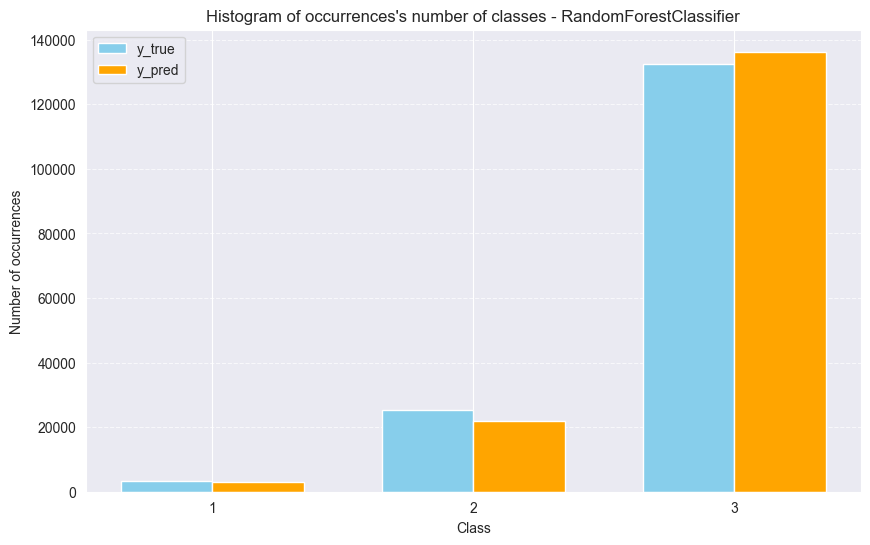

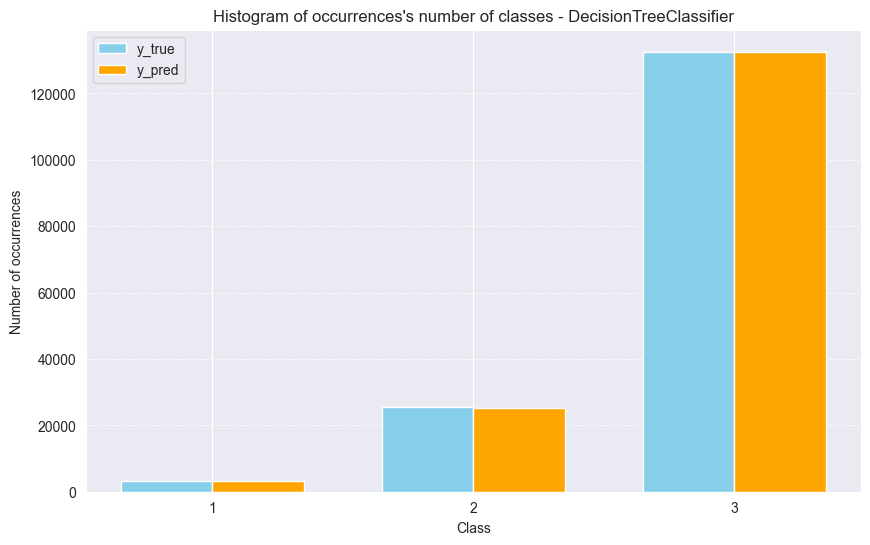

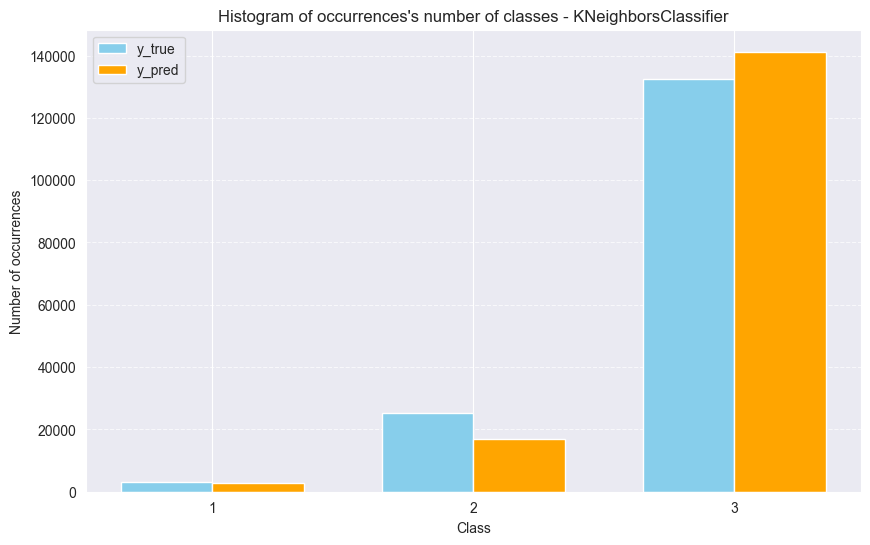

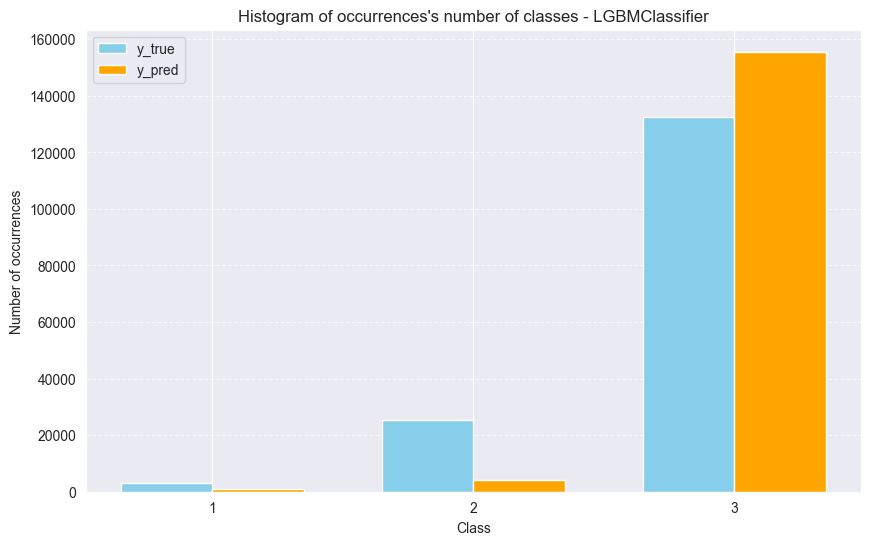

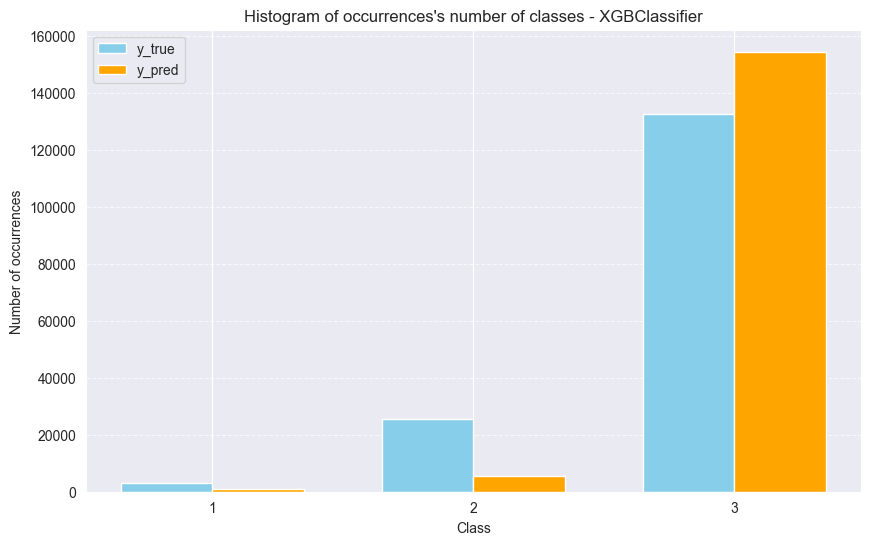

In [123]:
show_hist_y_and_pred(y_test_data, RandomForestClassifier_predictions, "RandomForestClassifier")

show_hist_y_and_pred(y_test_data, DecisionTreeClassifier_predictions, "DecisionTreeClassifier")

show_hist_y_and_pred(y_test_data, KNeighborsClassifier_predictions, "KNeighborsClassifier")

show_hist_y_and_pred(y_test_data, LGBMClassifier_predictions, "LGBMClassifier")

show_hist_y_and_pred(y_test_data, XGBClassifier_predictions + 1, "XGBClassifier")

<Figure size 800x600 with 0 Axes>

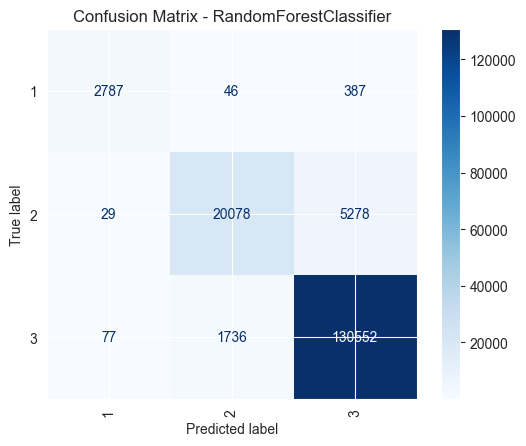

<Figure size 800x600 with 0 Axes>

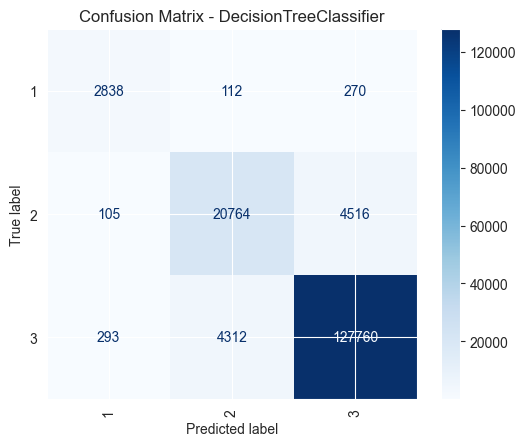

<Figure size 800x600 with 0 Axes>

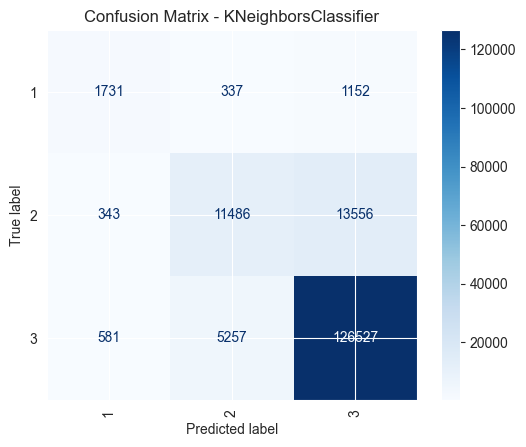

<Figure size 800x600 with 0 Axes>

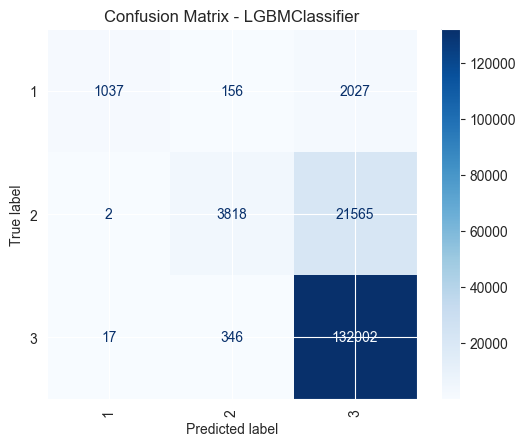

<Figure size 800x600 with 0 Axes>

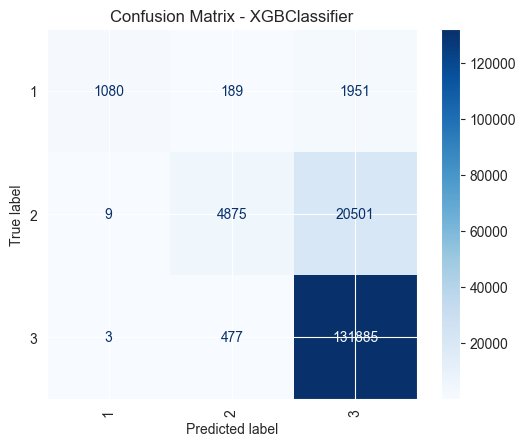

<Figure size 800x600 with 0 Axes>

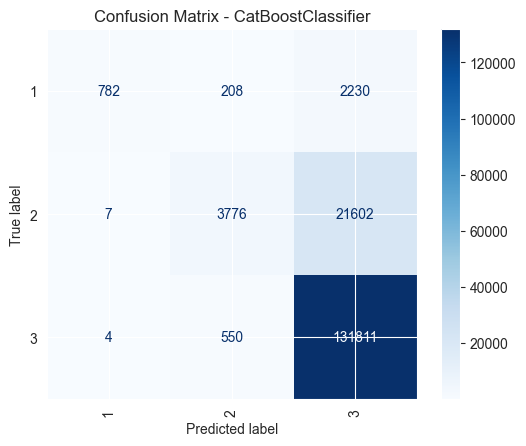

In [124]:
show_conf_matrix(y_test_data, RandomForestClassifier_predictions, "RandomForestClassifier")
show_conf_matrix(y_test_data, DecisionTreeClassifier_predictions, "DecisionTreeClassifier")
show_conf_matrix(y_test_data, KNeighborsClassifier_predictions, "KNeighborsClassifier")
show_conf_matrix(y_test_data, LGBMClassifier_predictions, "LGBMClassifier")
show_conf_matrix(y_test_data, XGBClassifier_predictions + 1, "XGBClassifier")
show_conf_matrix(y_test_data, CatBoostClassifier_predictions, "CatBoostClassifier")

In [125]:
results_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'Training Time'])

def add_result(model_name, accuracy_val, precision_val, recall_val, f1_score_val, training_time):
    results_df.loc[len(results_df)] = [model_name, accuracy_val, precision_val, recall_val, f1_score_val, training_time]

add_result('Random Forest', RandomForestClassifier_accuracy, RandomForestClassifier_precision, RandomForestClassifier_recall, RandomForestClassifier_score_f1, RandomForestClassifier_duration)
add_result('Decision Tree', DecisionTreeClassifier_accuracy, DecisionTreeClassifier_precision, DecisionTreeClassifier_recall, DecisionTreeClassifier_score_f1, DecisionTreeClassifier_duration)
add_result('KNN', KNeighborsClassifier_accuracy, KNeighborsClassifier_precision, KNeighborsClassifier_recall, KNeighborsClassifier_score_f1, KNeighborsClassifier_duration)
add_result('LGBM', LGBMClassifier_accuracy, LGBMClassifier_precision, LGBMClassifier_recall, LGBMClassifier_score_f1, LGBMClassifier_duration)
add_result('XGBoost', XGBClassifier_accuracy, XGBClassifier_precision, XGBClassifier_recall, XGBClassifier_score_f1, XGBClassifier_duration)
add_result('CatBoost', CatBoostClassifier_accuracy, CatBoostClassifier_precision, CatBoostClassifier_recall, CatBoostClassifier_f1_score, CatBoostClassifier_duration)

In [126]:
results_df

,Model,Accuracy,Precision,Recall,F1 Score,Training Time
0,Random Forest,0.968719,0.946751,0.880924,0.911312,51.240819
1,Decision Tree,0.960208,0.888420,0.888180,0.888294,2.057461
2,KNN,0.912091,0.740107,0.648648,0.685048,19.283161
3,LGBM,0.900135,0.904726,0.489904,0.552968,3.421052
4,XGBoost,0.421283,0.055647,0.288766,0.090429,3.652831
5,CatBoost,0.847170,0.847448,0.847170,0.800273,9.007301


In [128]:
import webbrowser

styled_results_df = results_df.style.highlight_max(color='tomato').highlight_min(color='limegreen')

with open('str.html','w') as f:
    styled_results_df.to_html(f)

filename = ' str.html'
webbrowser.open_new_tab(filename)

True

Analizując wyniki różnych modeli klasyfikacyjnych, można stwierdzić, że Random Forest i Decision Tree osiągnęły najwyższą skuteczność w klasyfikacji. Random Forest uzyskał najwyższą dokładność, co sugeruje, że agregacja wielu drzew decyzyjnych przyniosła korzyści. Jednakże, pomimo prostoty, pojedyncze drzewo decyzyjne również wykazało się wysoką dokładnością, co może być atrakcyjne ze względu na mniejsze wymagania obliczeniowe. 

Modele oparte na gradient boosting, takie jak XGBoost i LGBM, wykazały mieszane wyniki. W szczególności, XGBoost wydaje się mieć problemy z precyzją i czułością, co sugeruje, że wymaga on bardziej zaawansowanej regularyzacji lub optymalizacji. CatBoost, podobnie jak inne metody oparte na boostingu, uzyskał dobre wyniki, ale nieco niższe niż Random Forest i Decision Tree. Jego czas trenowania jest relatywnie krótki, co może być atrakcyjne w sytuacji, gdy obciążenie obliczeniowe jest istotne. Niemniej jednak, jego dokładność, precyzja i czułość są na zadowalającym poziomie. 

Algorytm KNN, mimo swojej popularności, nie osiągnął zadowalających wyników w tym zadaniu. Jego dokładność, precyzja i czułość były znacznie niższe niż w przypadku Random Forest i Decision Tree, a czas trenowania był najdłuższy spośród wszystkich modeli. Może to sugerować, że dla tego zestawu danych metoda oparta na odległościach nie jest odpowiednia.